<a href="https://colab.research.google.com/github/pepperamy/tenK_phase2/blob/main/104_of_10k_featureselection_cnnlstm_redolstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# packages


In [3]:
import pandas as pd
import pickle
import re
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mstats
import math

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from sklearn.model_selection import KFold,StratifiedKFold

In [5]:
from keras import regularizers

In [6]:
from keras import metrics

In [7]:
from keras import backend as K

In [8]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

In [9]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Reshape, Conv1D, MaxPooling1D, ZeroPadding1D,\
Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional,\
ZeroPadding2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import optimizers







from keras import models
from keras import layers

In [10]:
from sklearn.utils import class_weight

In [11]:
from sklearn import utils

In [12]:
import random

In [13]:
from sklearn.svm import LinearSVC,SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
#from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [14]:
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot as plt

# data prepare

In [15]:
df = pd.read_csv('data_performance_words_win1_comb_20210301.csv')

In [16]:
df.shape

(53635, 212)

In [17]:
sum(df.label)

487.0

In [18]:
df.head()

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down
0,20.0,1995.0,1996.0,0.633505,1.0,0.0,3,0.063117,-0.072425,-0.067847,0.661974,-0.147079,0.198730,1,0.974056,1.624273,0.206066,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528,NaN,NaN,NaN,NaN,NaN,NaN,-0.000071,0.000000,0.095238,0.004950,0.047619,0.761905,-0.002775,0.002801,0.190476,0.000000,...,0.047619,0.571429,-0.004527,0.016180,0.428571,0.029638,0.285714,0.190476,-0.000009,0.002644,0.190476,0.000000,0.190476,0.523810,-0.002433,0.002488,0.333333,0.019737,0.000000,0.571429,0.052570,0.095238,0.142857,0.193277,0.047619,0.058512,0.353070,0.338308,0.238095,0.292404,0.100189,0.145658,0.395804,0.355975,0.060777,0.303224,0.190476,0.248916,0.190476,0.193121
1,20.0,1996.0,1997.0,0.803827,1.0,0.0,3,0.066126,-0.018252,-0.059281,0.620435,-0.066028,0.034753,1,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432,0.633505,0.633505,0.633505,1.268856,1.268856,1.268856,-0.000034,0.000000,0.066667,0.028571,0.000000,0.866667,0.003234,0.000000,0.133333,0.000000,...,0.133333,0.733333,-0.003780,0.018289,0.333333,0.000000,0.200000,0.400000,0.000668,0.007947,0.200000,0.000000,0.200000,0.533333,-0.001054,0.013954,0.066667,0.000000,0.066667,0.800000,0.028571,0.066667,0.200000,0.133333,0.161905,0.066667,0.161905,0.357243,0.200000,0.219242,0.123810,0.134598,0.333333,0.144428,0.133333,0.075494,0.133333,0.070482,0.200000,0.207947
2,20.0,1997.0,1998.0,0.462705,1.0,0.0,3,0.095900,0.066711,0.013223,0.656729,-0.030720,0.019574,1,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269,0.718666,0.718666,0.803827,0.643838,0.643838,0.575627,0.002823,0.005714,0.066667,0.007841,0.133333,0.466667,-0.001499,0.004000,0.133333,0.004315,...,0.066667,0.333333,0.000062,0.028035,0.266667,0.021889,0.266667,0.133333,-0.003310,0.001504,0.266667,0.002960,0.000000,0.400000,-0.000069,0.011111,0.066667,0.004688,0.066667,0.533333,0.141174,0.072381,0.137649,0.137333,0.074024,0.139048,0.149893,0.299598,0.070786,0.271178,0.154181,0.144762,0.484144,0.236060,0.074921,0.277778,0.076624,0.202532,0.002960,0.268170
3,20.0,1998.0,1999.0,0.701689,1.0,0.0,3,0.054997,0.026323,-0.009875,0.676757,0.011434,0.002424,1,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057,0.633346,0.633346,0.462705,1.107909,1.107909,1.516495,0.000590,0.006755,0.045455,0.000000,0.136364,0.545455,-0.000112,0.005460,0.090909,0.000000,...,0.090909,0.590909,0.001965,0.034894,0.090909,0.019415,0.136364,0.500000,0.000347,0.003575,0.000000,0.008179,0.045455,0.681818,-0.000126,0.003620,0.090909,0.000000,0.090909,0.545455,0.136364,0.052210,0.045455,0.096370,0.048976,0.140434,0.093257,0.110468,0.045455,0.050488,0.187374,0.063963,0.195518,0.159758,0.101197,0.055574,0.103194,0.144520,0.053633,0.003575
4,20.0,1999.0,2000.0,0.823023,1.0,0.0,3,-0.024892,-0.024929,0.041267,0.705573,-0.001713,-0.014429,1,1.093648,1.560280,-0.015406,0.942174,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184,0.650432,0.656074,0.701689,1.265350,1.254468,1.172917,-0.000791,0.002083,0.176471,0.000000,0.000000,0.764706,-0.000278,0.003717,0.117647,0.000000,...,0.176471,0.647059,-0.001826,0.011784,0.117647,0.054348,0.058824,0.

In [19]:
df_fl = df[(df.y2 <= 2012) & (df.y2 >= 1995 ) ]

In [20]:
df_fl.label.value_counts()

0.0    53148
1.0      487
Name: label, dtype: int64

In [21]:
df_fl.shape

(53635, 212)

In [22]:
selected_new = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
         'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']#[::-1]

v_perf = ['aqi',
 'asset_turnover',
 'depi',
 'gmi',
 #'ig',
 'opm',
 'rg',
 'sg',
 'sgee',
 'ch_rec',
 'ch_inv',
 'soft_asset',
 'ch_cs',
 'ch_roa',
 'issue']

v_1 = ['s1']
v_2 = ['pastavg3','cr3']

In [36]:
# selected_comb = []
# for s in selected_new:
#   selected_comb.append(s+'_up')
#   selected_comb.append(s+'_down')

In [23]:
selected_new_all = []
temp = []
for s in selected_new:
    wrd = s.split('_')[0]
    if wrd not in temp:
        #print(s,'\n',temp)
        #selected_new_all.append(wrd+'_3_avg')
        selected_new_all.append(wrd+'_3_p')
        selected_new_all.append(wrd+'_3_n')
        #selected_new_all.append(wrd+'_3_u')
        selected_new_all.append(wrd+'_3_new')
        selected_new_all.append(wrd+'_3_dis')
        temp.append(wrd)
    else: 
        pass

In [24]:
selected_new_all

['WeakModal_3_p',
 'WeakModal_3_n',
 'WeakModal_3_new',
 'WeakModal_3_dis',
 'Negative_3_p',
 'Negative_3_n',
 'Negative_3_new',
 'Negative_3_dis',
 'Compare_3_p',
 'Compare_3_n',
 'Compare_3_new',
 'Compare_3_dis',
 'Discrep_3_p',
 'Discrep_3_n',
 'Discrep_3_new',
 'Discrep_3_dis',
 'Positive_3_p',
 'Positive_3_n',
 'Positive_3_new',
 'Positive_3_dis',
 'Achieve_3_p',
 'Achieve_3_n',
 'Achieve_3_new',
 'Achieve_3_dis',
 'Reward_3_p',
 'Reward_3_n',
 'Reward_3_new',
 'Reward_3_dis',
 'StrongModal_3_p',
 'StrongModal_3_n',
 'StrongModal_3_new',
 'StrongModal_3_dis',
 'Uncertainty_3_p',
 'Uncertainty_3_n',
 'Uncertainty_3_new',
 'Uncertainty_3_dis',
 'Litigious_3_p',
 'Litigious_3_n',
 'Litigious_3_new',
 'Litigious_3_dis']

In [25]:
selected_new_all_sorted = []
selected_new_all_p = []
selected_new_all_n = []
selected_new_all_new = []
selected_new_all_dis = []
for s in selected_new_all:
  if 'new' in s.split('_'):
    selected_new_all_new.append(s)
  elif 'p' in s.split('_'):
    selected_new_all_p.append(s)
  elif 'n' in s.split('_'):
    selected_new_all_n.append(s)
  elif 'dis' in s.split('_'):
    selected_new_all_dis.append(s)

for i, w in enumerate(selected_new_all_p):
  selected_new_all_sorted.append(selected_new_all_p[i])
  selected_new_all_sorted.append(selected_new_all_new[i])
  selected_new_all_sorted.append(selected_new_all_n[i])
  
  selected_new_all_sorted.append(selected_new_all_dis[i])  


In [26]:
selected_new_all_sorted

['WeakModal_3_p',
 'WeakModal_3_new',
 'WeakModal_3_n',
 'WeakModal_3_dis',
 'Negative_3_p',
 'Negative_3_new',
 'Negative_3_n',
 'Negative_3_dis',
 'Compare_3_p',
 'Compare_3_new',
 'Compare_3_n',
 'Compare_3_dis',
 'Discrep_3_p',
 'Discrep_3_new',
 'Discrep_3_n',
 'Discrep_3_dis',
 'Positive_3_p',
 'Positive_3_new',
 'Positive_3_n',
 'Positive_3_dis',
 'Achieve_3_p',
 'Achieve_3_new',
 'Achieve_3_n',
 'Achieve_3_dis',
 'Reward_3_p',
 'Reward_3_new',
 'Reward_3_n',
 'Reward_3_dis',
 'StrongModal_3_p',
 'StrongModal_3_new',
 'StrongModal_3_n',
 'StrongModal_3_dis',
 'Uncertainty_3_p',
 'Uncertainty_3_new',
 'Uncertainty_3_n',
 'Uncertainty_3_dis',
 'Litigious_3_p',
 'Litigious_3_new',
 'Litigious_3_n',
 'Litigious_3_dis']

# SVM
#### variables:
#### A. Quant. Indicators
#### B. Overall Similarity+ Word Changes
#### C. Quant. Indicators + Overall Similarity
#### D. Quant. Indicators + Overall Similarity + Word Changes


In [ ]:
def svm( data, vs, label = 'label'):
    
    columns_fl = vs[1] #+ [ 'sic_class_x']
    
    data_target = data.loc[:,columns_fl + [label]]
    
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []

    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    print('dataset: ', data_target.shape, '/n', sum(data_target.label))
     
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        svm = LinearSVC(class_weight = "balanced")
        svm.fit(train_x, train_y )
        pickle.dump(svm, open('svm_'+str(vs[0])+ '_'+str(c), 'wb'))
        

        pred = svm.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = svm.decision_function(test_x)
        auc_score = roc_auc_score(test_y, decision_values)
        print(auc_score)
        auc_list.append(auc_score)
        
        fpr, tpr, thresholds = roc_curve(test_y, decision_values)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
#         mean_tpr = np.mean(tprs, axis=0)
#         mean_auc = auc(mean_fpr, mean_tpr)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
    
#     coef_s = 0
#     for i in coef:
#         coef_s += abs(i)
#     coef_avg = coef_s / len(coef)
#     coef_top = pd.DataFrame(coef_avg, index = columns_fl,columns = ['importance'])
#     coef_top = coef_top.sort_values('importance',ascending=False)
#     print(coef_top.iloc[0:10,:])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [ ]:
# without timestep
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
#    print(fl)
    svm_model = svm( df_fl, fl,label = 'label')
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

dataset:  (53635, 15) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  2783.0 

0.6877701241321791
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  2978.0 

0.6698800874020828
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  3471.0 

0.6530597514888828
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  3124.0 

0.6917275134397818
avg_AUC :  0.6756093691157317
avg_AUC_2 :  0.6754415856163587
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6756093691157317
dataset:  (53635, 16) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  2745.0 

0.6795456424188809
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  2844.0 

0.6628270946456971
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  2886.0 

0.7010945001091909
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  2733.0 

0.683788976611079
avg_AUC :  0.681814053446211

# SVM with timestep (flat the T-year data and feed into SVM)
##### T =1,2,3
##### variables:
##### A. Quant. Indicators
##### B. Overall Similarity+ Word Changes
##### C. Quant. Indicators + Overall Similarity
##### D. Quant. Indicators + Overall Similarity + Word Changes

In [ ]:
def svm_2( data, y, vs):
    
    # columns_fl = vs[1] #+ [ 'sic_class_x']
    
    # data_target = data.loc[:,columns_fl + [label]]
    
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []

    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    # data_target = data[columns_fl + [label]]
    # data_target = data_target.dropna()
    # data_target = data_target.reset_index(drop = True)
    # print('dataset: ', data_target.shape, '/n', sum(data_target.label))
     
    for train_index, test_index in kf.split(data, y):
        
        c += 1

        train_x = data[train_index]
        train_y = y[train_index]
        test_x = data[test_index]
        test_y = y[test_index] 

        print('iterate_num: ', c, '\n','sum of train_y:', sum(train_y), 'train_x shape', train_x.shape)
    
        svm = LinearSVC(class_weight = "balanced")
        svm.fit(train_x, train_y )
        pickle.dump(svm, open('svm_'+str(vs)+ '_'+str(c), 'wb'))
        

        pred = svm.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = svm.decision_function(test_x)
        auc_score = roc_auc_score(test_y, decision_values)
        print(auc_score)
        auc_list.append(auc_score)
        
        fpr, tpr, thresholds = roc_curve(test_y, decision_values)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
#         mean_tpr = np.mean(tprs, axis=0)
#         mean_auc = auc(mean_fpr, mean_tpr)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
    
#     coef_s = 0
#     for i in coef:
#         coef_s += abs(i)
#     coef_avg = coef_s / len(coef)
#     coef_top = pd.DataFrame(coef_avg, index = columns_fl,columns = ['importance'])
#     coef_top = coef_top.sort_values('importance',ascending=False)
#     print(coef_top.iloc[0:10,:])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [ ]:
# Generate the flat structure T-year data  
def shift_data_2(data, step, cols, label):
    A = []
    
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    D = A[:,1:]

    
    print(D.shape, Y.sum())
    # return A_perf, A_words, Y
    return D, Y

In [ ]:
# with timestep = 1
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
    print(fl)
    data, y = shift_data_2(df_fl, 1, fl[1], 'label')
    svm_model = svm_2(data, y, fl[0])
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
(53635, 14) 487.0
iterate_num:  1 
 sum of train_y: 365.0 train_x shape (40226, 14)
sum of pred:  3063.0 

0.6622052616448717
iterate_num:  2 
 sum of train_y: 365.0 train_x shape (40226, 14)
sum of pred:  2930.0 

0.7009581656913513
iterate_num:  3 
 sum of train_y: 365.0 train_x shape (40226, 14)
sum of pred:  2981.0 

0.6571374460677083
iterate_num:  4 
 sum of train_y: 366.0 train_x shape (40227, 14)
sum of pred:  3009.0 

0.6773967222047027
avg_AUC :  0.6744243989021584
avg_AUC_2 :  0.6742952831389356
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6744243989021584
('perf+spc', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1'

In [ ]:
# with timestep = 2
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
    print(fl)
    data, y = shift_data_2(df_fl, 2, fl[1], 'label')
    svm_model = svm_2(data, y, fl[0])
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
(45945, 28) 408.0
iterate_num:  1 
 sum of train_y: 306.0 train_x shape (34458, 28)
sum of pred:  1088.0 

0.6581854349117776
iterate_num:  2 
 sum of train_y: 306.0 train_x shape (34459, 28)
sum of pred:  837.0 

0.7074256266104475
iterate_num:  3 
 sum of train_y: 306.0 train_x shape (34459, 28)
sum of pred:  724.0 

0.6847174569054607
iterate_num:  4 
 sum of train_y: 306.0 train_x shape (34459, 28)
sum of pred:  1155.0 

0.6671498008901382
avg_AUC :  0.6793695798294559
avg_AUC_2 :  0.6793672014260249
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6793695798294559
('perf+spc', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1'])

In [ ]:
# with timestep = 3
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
    print(fl)
    data, y = shift_data_2(df_fl, 3, fl[1], 'label')
    svm_model = svm_2(data, y, fl[0])
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
(39123, 42) 341.0
iterate_num:  1 
 sum of train_y: 256.0 train_x shape (29342, 42)
sum of pred:  190.0 

0.6508323626480295
iterate_num:  2 
 sum of train_y: 256.0 train_x shape (29342, 42)
sum of pred:  196.0 

0.6697619394292371
iterate_num:  3 
 sum of train_y: 255.0 train_x shape (29342, 42)
sum of pred:  229.0 

0.675544814517193
iterate_num:  4 
 sum of train_y: 256.0 train_x shape (29343, 42)
sum of pred:  122.0 

0.7053981737099171
avg_AUC :  0.6753843225760942
avg_AUC_2 :  0.6753603062084595
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6753843225760942
('perf+spc', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1'])
(3

# LR
##### variables:
##### A. Quant. Indicators
##### B. Overall Similarity+ Word Changes
##### C. Quant. Indicators + Overall Similarity
##### D. Quant. Indicators + Overall Similarity + Word Changes

In [ ]:
def lg( data,vs, label = 'label'):
    
    
    columns_fl = vs[1]# + [ 'sic_class_x']
    data_target = data.loc[:,columns_fl + [label]]
    
        
#     train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,test_size=0.2, random_state=19, 
#                                                                         stratify = data_y) 

    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        lg = LogisticRegression(class_weight = 'balanced')
        lg.fit(train_x, train_y )
        pickle.dump(lg, open('lg_'+str(vs[0])+ '_'+str(c), 'wb'))

        pred = lg.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = lg.predict_proba(test_x)
        auc_score = roc_auc_score(test_y, decision_values[:,1])
        print(auc_score)
        auc_list.append(auc_score)
        fpr, tpr, thresholds = roc_curve(test_y, decision_values[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
        #print('AUC',auc_score)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [ ]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf+v_1+selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    lg_model = lg( df_fl, fl, label = 'label')
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  5465.0 

0.7064343676242154
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  5157.0 

0.6820095323050881
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  5133.0 

0.6600424178939849
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  5351.0 

0.6788254473551791
avg_AUC :  0.6818279412946169
avg_AUC_2 :  0.6821228474967805
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6818279412946169
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  5120.0 

0.6953308237930086
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  5167.0 

0.6567814960265612
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  5140.0 

0.6989279549713945
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  5269.0 

0.6810353996667344
avg_AUC :  0.6830189186144248
avg_AUC_2 :  0.682872793782562
frauds_prec :  nan
fradus_re

# LG with timestepwith timestep (flat the T-year data and feed into LG)
##### T=1,2,3
##### variables:
##### A. Quant. Indicators
##### B. Overall Similarity+ Word Changes
##### C. Quant. Indicators + Overall Similarity
##### D. Quant. Indicators + Overall Similarity + Word Changes



In [ ]:
def lg_2( data, y, vs):
    
    
    # columns_fl = vs[1]# + [ 'sic_class_x']
    # data_target = data.loc[:,columns_fl + [label]]
    
        
#     train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,test_size=0.2, random_state=19, 
#                                                                         stratify = data_y) 

    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    # data_target = data[columns_fl + [label]]
    # data_target = data_target.dropna()
    # data_target = data_target.reset_index(drop = True)
    for train_index, test_index in kf.split(data, y):
        
        c += 1

        train_x = data[train_index]
        train_y = y[train_index]
        test_x = data[test_index]
        test_y = y[test_index] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        lg = LogisticRegression(class_weight = 'balanced')
        lg.fit(train_x, train_y )
        #pickle.dump(lg, open('lg_'+str(vs[0])+ '_'+str(c), 'wb'))

        pred = lg.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = lg.predict_proba(test_x)
        auc_score = roc_auc_score(test_y, decision_values[:,1])
        print(auc_score)
        auc_list.append(auc_score)
        fpr, tpr, thresholds = roc_curve(test_y, decision_values[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
        #print('AUC',auc_score)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [ ]:
# timestep = 1
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    print(fl)
    data, y = shift_data_2(df_fl, 1, fl[1], 'label')
    lg_model = lg_2(data, y, fl[0])
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
(53635, 14) 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  5321.0 

0.7036028066383141
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  5372.0 

0.7118815753596206
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  5175.0 

0.6403399353737846
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  5094.0 

0.6531998280802649
avg_AUC :  0.677256036362996
avg_AUC_2 :  0.6773503220800334
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.677256036362996
('perf+spc', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1'])
(53635, 15) 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  5283.0 

0.6970902163707408
iterate_

In [ ]:
# timestep = 2
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    print(fl)
    data, y = shift_data_2(df_fl, 2, fl[1], 'label')
    lg_model = lg_2(data, y, fl[0])
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
(45945, 28) 408.0
iterate_num:  1 
 sum of test_y: 102.0
sum of pred:  4437.0 

0.6956039508469176
iterate_num:  2 
 sum of test_y: 102.0
sum of pred:  4334.0 

0.6859489755143097
iterate_num:  3 
 sum of test_y: 102.0
sum of pred:  4349.0 

0.6818772132886886
iterate_num:  4 
 sum of test_y: 102.0
sum of pred:  4394.0 

0.670438730657407
avg_AUC :  0.6834672175768307
avg_AUC_2 :  0.6832293523469994
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6834672175768307
('perf+spc', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1'])
(45945, 30) 408.0
iterate_num:  1 
 sum of test_y: 102.0
sum of pred:  4398.0 

0.7186054922627814
iterate

In [ ]:
# timestep = 3
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    print(fl)
    data, y = shift_data_2(df_fl, 3, fl[1], 'label')
    lg_model = lg_2(data, y, fl[0])
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
(39123, 42) 341.0
iterate_num:  1 
 sum of test_y: 85.0
sum of pred:  3789.0 

0.6636466220151427
iterate_num:  2 
 sum of test_y: 85.0
sum of pred:  3768.0 

0.6677501941370607
iterate_num:  3 
 sum of test_y: 86.0
sum of pred:  3664.0 

0.7004341724936134
iterate_num:  4 
 sum of test_y: 85.0
sum of pred:  3659.0 

0.7014749871067562
avg_AUC :  0.6833264939381433
avg_AUC_2 :  0.6832500794539099
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6833264939381433
('perf+spc', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1'])
(39123, 45) 341.0
iterate_num:  1 
 sum of test_y: 85.0
sum of pred:  3588.0 

0.7018321685109687
iterate_num

# NN 
##### T=1
##### variables:
##### A. Quant. Indicators
##### C. Quant. Indicators + Overall Similarity


In [ ]:
def model_M1(n1,n2):
    model_m1 = None
    model_m1 = Sequential(name = 'M1')
    model_m1.add(BatchNormalization())
    model_m1.add(layers.Dense(n1,name = 'layer_1',activation='relu'))
    model_m1.add(layers.Dropout(0.3))
    #model_m1.add(layers.Dense(64,name = 'layer_2'))
    model_m1.add(BatchNormalization())
    model_m1.add(layers.Dense(n2,name = 'layer_2',activation='relu'))
    model_m1.add(layers.Dense(1,activation='sigmoid'))
    
    return model_m1

In [ ]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [ ]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [ ]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    print('class_weights',class_weights)
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights))
    model_df.summary()
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [ ]:
def cross_val(n1, n2, data,label,columns_fl,model_name):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_1 = data[columns_fl + [label]]
    data_1 = data_1.dropna()
    data_target = data_1.reset_index(drop = True)
    
    predicted_res =[]
    print('dataset: ', data_target.shape, '/n', sum(data_target.label))
    
    
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_data = data_target.loc[train_index,columns_fl]
        train_label = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl].to_numpy()
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
        train_x, val_x, train_y, val_y = train_test_split(train_data.to_numpy(), train_label.to_numpy(),test_size=0.2, \
                                  random_state=42, stratify = train_label)
        print('train_x_shape',train_x.shape)
        model = model_M1(n1,n2)
        mod_res = fit_model(model, train_x, train_y, val_x, val_y, test_x, test_y, model_name+'_'+str(c)+'_NN_model')
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
#         print(type(mod_res[-1]))
#         print(len(mod_res[-1]))
#         print(mod_res[-1])
        temp_pred_res = [mod_res[-1],test_index]
        #print(temp_pred_res)
        predicted_res.append(temp_pred_res)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.mean(auc_list),mean_tpr, predicted_res

In [ ]:
label = 'label'
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1 ,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
#
mean_tpr_dict_nn = dict()
pred_res_nn = dict()
for fl in vs_fl.items():
    print(fl[1])
    n1 = len(fl[1])*2
    n2 = len(fl[1])
    #M1 = model_M1(n1,n2)
    NN = cross_val(n1, n2, df_fl, label, fl[1], fl[0])
    print(fl)
    print(NN[0])
    mean_tpr_dict_nn[fl[0]] = NN[1]
    pred_res_nn[fl[0]] = NN[2]

['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue']
dataset:  (53635, 15) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
train_x_shape (32180, 14)
class_weights {0.0: 0.5045785248369292, 1.0: 55.102739726027394}
Epoch 1/30
63/63 [==============================] - 3s 23ms/step - loss: 0.8369 - accuracy: 0.8020 - my_auc: 0.5571 - val_loss: 0.6769 - val_accuracy: 0.4998 - val_my_auc: 0.6139
 epoch:0 auc: 0.6148
Epoch 2/30
63/63 [==============================] - 0s 5ms/step - loss: 0.7265 - accuracy: 0.7375 - my_auc: 0.5931 - val_loss: 0.6765 - val_accuracy: 0.2964 - val_my_auc: 0.6382
 epoch:1 auc: 0.6387
Epoch 3/30
63/63 [==============================] - 0s 5ms/step - loss: 0.7119 - accuracy: 0.6922 - my_auc: 0.5843 - val_loss: 0.6728 - val_accuracy: 0.3271 - val_my_auc: 0.6478
 epoch:2 auc: 0.6481
Epoch 4/30
63/63 [==============================] - 0s 5ms/step - loss: 0.7050 - accuracy: 0.6466 - my_auc: 0.6



---



# LSTM
##### T =2,3
##### variables:
##### A. Quant. Indicators
##### C. Quant. Indicators + Overall Similarity



In [85]:
def model_lstm(n1,n2,n,w,l):
    model = None
    
    input_all = Input(shape=(w,l), \
               dtype='float32', name='input')
    #nor = BatchNormalization()(input_all)
    LSTM_w_1 = Bidirectional(LSTM(n1, dropout = 0.2, recurrent_dropout = 0.2, \
              name = 'layer_lstm_1', return_sequences=True))(input_all)
    LSTM_w_2 = LSTM(n2, activation='relu', dropout = 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(n, activation='relu', name='dense')(LSTM_w_2)
    drop = Dropout(0.3)(dense)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=input_all, outputs=preds)
    model._name = "model_lstm"
    model.summary()
    
    return model

In [50]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [51]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [73]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, epoch, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    print(class_weights)
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=epoch,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights)) 
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1= np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [53]:
def cross_val(data, label, perf_cols, name, w, epoch):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf,  Y = shift_data(df_fl, w, \
                    perf_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1] + 16
        
        model = model_lstm(l1,l1,32,\
                    X_perf.shape[1],X_perf.shape[2])
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        #train_word_data = X_word[train_x]
        #train_perf_val = X_perf[train_val]
        #train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        #test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        # train_data = [train_perf_data, train_word_data]
        # val_data = [train_perf_val,train_word_val]       
        # test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_perf_data, train_label, test_perf_x, test_y, test_perf_x, test_y,\
                  name+'_'+str(c), epoch)
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [54]:
def shift_data(data, step, perf_cols, label):
    A = []
    
    cols = perf_cols #+ words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    #A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # # CNN_LSTM must be None x T x words x 4
    # A_words = A[:, :, len(perf_cols):]
    # #convert the shape to [[_p,_new][_dis,_n]]
    # A_words = A_words.reshape((len(A), step, int(len(words_cols)/2), 2), order = 'C')
    
    print(A_perf.shape, Y.sum())
    return A_perf, Y


In [88]:
# financial performance + overall change + word change timestep = 1
# cross_val(df_fl, 'label', v_perf + v_1 +selected_new_all, 'lstm_wrdperf', 1, epoch = 10)

In [87]:
# financial performance + overall change + word change timestep = 2
cross_val(df_fl, 'label', v_perf + v_1 +selected_new_all, 'lstm_perf', 2, epoch = 30)

init A shape:  (53635, 111)
(45945, 2, 55) 408.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 55)]           0         
_________________________________________________________________
bidirectional_113 (Bidirecti (None, 2, 142)            72136     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 71)                60776     
_________________________________________________________________
dense (Dense)                (None, 32)                2304      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 135,249
Trainable params: 135,249
Non-trainable params: 0
_

(0.7070484548750304,
 array([0.        , 0.06862745, 0.09803922, 0.12254902, 0.15441176,
        0.17401961, 0.21078431, 0.24509804, 0.25980392, 0.27696078,
        0.28676471, 0.30147059, 0.32352941, 0.34313725, 0.36519608,
        0.3872549 , 0.3995098 , 0.41176471, 0.42156863, 0.42892157,
        0.43137255, 0.45098039, 0.47303922, 0.48529412, 0.49754902,
        0.52696078, 0.54656863, 0.56127451, 0.56617647, 0.57598039,
        0.58578431, 0.60294118, 0.60784314, 0.62254902, 0.63480392,
        0.6372549 , 0.65931373, 0.66911765, 0.67647059, 0.68627451,
        0.70098039, 0.71078431, 0.7254902 , 0.7377451 , 0.75      ,
        0.75980392, 0.76715686, 0.76960784, 0.78431373, 0.79656863,
        0.80147059, 0.80392157, 0.81617647, 0.82352941, 0.82843137,
        0.83333333, 0.84068627, 0.84558824, 0.8504902 , 0.85294118,
        0.85539216, 0.86029412, 0.86764706, 0.87254902, 0.88235294,
        0.8995098 , 0.90196078, 0.90441176, 0.91176471, 0.91911765,
        0.92401961, 0.93137

In [86]:
# financial performance + overall change + word change timestep = 3
cross_val(df_fl, 'label', v_perf + v_1 +selected_new_all, 'lstm_perf', 3, epoch = 50)

init A shape:  (53635, 166)
(39123, 3, 55) 341.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 55)]           0         
_________________________________________________________________
bidirectional_109 (Bidirecti (None, 3, 142)            72136     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 71)                60776     
_________________________________________________________________
dense (Dense)                (None, 32)                2304      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 135,249
Trainable params: 135,249
Non-trainable params: 0
_

(0.7169429367919189,
 array([0.00294118, 0.07038304, 0.11443228, 0.14671683, 0.18197674,
        0.19363885, 0.21415869, 0.22886457, 0.24651163, 0.27886457,
        0.30817373, 0.32872777, 0.3375171 , 0.35803694, 0.36097811,
        0.36682627, 0.3873461 , 0.41077291, 0.4370725 , 0.45174419,
        0.46344049, 0.48392613, 0.49268126, 0.50444596, 0.51621067,
        0.53088235, 0.53963748, 0.54551984, 0.56603967, 0.57770178,
        0.58652531, 0.60123119, 0.60707934, 0.6129617 , 0.62766758,
        0.64230506, 0.65991792, 0.67749658, 0.68922709, 0.70386457,
        0.72735978, 0.73909029, 0.74784542, 0.75954172, 0.75954172,
        0.76836525, 0.77715458, 0.79473324, 0.80355677, 0.81816005,
        0.81816005, 0.82110123, 0.82404241, 0.82404241, 0.82694938,
        0.83570451, 0.84445964, 0.85619015, 0.85913133, 0.87380301,
        0.89141587, 0.89435705, 0.90314637, 0.90314637, 0.90902873,
        0.90902873, 0.9119357 , 0.91781806, 0.91781806, 0.92072503,
        0.92660739, 0.93543

In [89]:
# financial performance + overall change timestep = 3
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 3, epoch=50)

init A shape:  (53635, 46)
(39123, 3, 15) 341.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 15)]           0         
_________________________________________________________________
bidirectional_117 (Bidirecti (None, 3, 62)             11656     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 31)                11656     
_________________________________________________________________
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 24,369
Trainable params: 24,369
Non-trainable params: 0
____

(0.6808195511448913,
 array([0.        , 0.05875513, 0.09391245, 0.12024624, 0.14668263,
        0.16727086, 0.17903557, 0.19664843, 0.22311902, 0.23194254,
        0.25834473, 0.27004104, 0.29350205, 0.31692886, 0.34329685,
        0.34917921, 0.36385089, 0.37260602, 0.39599863, 0.40769494,
        0.41645007, 0.43101915, 0.45150479, 0.46621067, 0.48967168,
        0.50143639, 0.50434337, 0.51316689, 0.53368673, 0.54247606,
        0.55424077, 0.56894665, 0.58652531, 0.60707934, 0.61590287,
        0.62171683, 0.62759918, 0.63344733, 0.63929549, 0.64514364,
        0.65102599, 0.66573187, 0.6745554 , 0.68915869, 0.69500684,
        0.70967852, 0.72431601, 0.72725718, 0.73313953, 0.74490424,
        0.7624829 , 0.76836525, 0.78006156, 0.78590971, 0.79767442,
        0.80355677, 0.80646375, 0.80940492, 0.82116963, 0.82116963,
        0.82701778, 0.83290014, 0.83871409, 0.8504104 , 0.8504104 ,
        0.85919973, 0.8621409 , 0.8621409 , 0.87089603, 0.87677839,
        0.88262654, 0.88556

In [83]:
v_1

['s1']

In [90]:
# financial performance + overall change timestep = 2
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 2, epoch=50)

init A shape:  (53635, 31)
(45945, 2, 15) 408.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 15)]           0         
_________________________________________________________________
bidirectional_121 (Bidirecti (None, 2, 62)             11656     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 31)                11656     
_________________________________________________________________
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 24,369
Trainable params: 24,369
Non-trainable params: 0
____

(0.6813652683845886,
 array([0.        , 0.05882353, 0.08823529, 0.11764706, 0.15686275,
        0.17892157, 0.19607843, 0.21813725, 0.24019608, 0.25      ,
        0.27205882, 0.29411765, 0.30882353, 0.31862745, 0.33578431,
        0.34803922, 0.3627451 , 0.37254902, 0.38235294, 0.3995098 ,
        0.41421569, 0.43872549, 0.45343137, 0.4754902 , 0.48284314,
        0.49264706, 0.50735294, 0.50735294, 0.51960784, 0.53431373,
        0.54166667, 0.56127451, 0.57843137, 0.58823529, 0.59313725,
        0.60539216, 0.61029412, 0.61519608, 0.625     , 0.64460784,
        0.65196078, 0.66911765, 0.68137255, 0.69852941, 0.71323529,
        0.73039216, 0.7377451 , 0.74509804, 0.75      , 0.75735294,
        0.7622549 , 0.77205882, 0.77696078, 0.78186275, 0.79411765,
        0.80147059, 0.80392157, 0.81372549, 0.81617647, 0.82107843,
        0.82843137, 0.83578431, 0.84313725, 0.84558824, 0.85539216,
        0.86519608, 0.87254902, 0.87254902, 0.87990196, 0.88235294,
        0.89215686, 0.90196

In [91]:
# financial performance timestep = 3
cross_val(df_fl, 'label', v_perf, 'lstm_perf', 3, epoch=50)

init A shape:  (53635, 43)
(39123, 3, 14) 341.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 14)]           0         
_________________________________________________________________
bidirectional_125 (Bidirecti (None, 3, 60)             10800     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 30)                10920     
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 22,745
Trainable params: 22,745
Non-trainable params: 0
____

(0.6812921369206903,
 array([0.        , 0.0498974 , 0.07335841, 0.11432969, 0.13491792,
        0.15844733, 0.17606019, 0.20253078, 0.21720246, 0.2377223 ,
        0.25824213, 0.26997264, 0.29045828, 0.30516416, 0.31692886,
        0.32869357, 0.34627223, 0.36090971, 0.37260602, 0.39316005,
        0.39606703, 0.40194938, 0.41367989, 0.44008208, 0.46053352,
        0.47219562, 0.49562244, 0.51029412, 0.52783858, 0.54247606,
        0.55424077, 0.5630301 , 0.57175103, 0.58348153, 0.58936389,
        0.59818741, 0.60406977, 0.61874145, 0.63047196, 0.64220246,
        0.64514364, 0.65981532, 0.66562927, 0.6744528 , 0.68327633,
        0.69497264, 0.70967852, 0.72725718, 0.74777702, 0.75660055,
        0.75660055, 0.76829685, 0.77708618, 0.78885089, 0.79175787,
        0.79469904, 0.79764022, 0.80930233, 0.82985636, 0.83867989,
        0.84746922, 0.84746922, 0.85916553, 0.86504788, 0.86798906,
        0.86798906, 0.87093023, 0.88262654, 0.89141587, 0.90605335,
        0.90605335, 0.91484

In [92]:
# financial performance timestep = 2
cross_val(df_fl, 'label', v_perf, 'lstm_perf', 2, epoch=5


0
          )

init A shape:  (53635, 29)
(45945, 2, 14) 408.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 14)]           0         
_________________________________________________________________
bidirectional_129 (Bidirecti (None, 2, 60)             10800     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 30)                10920     
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 22,745
Trainable params: 22,745
Non-trainable params: 0
____

(0.679356036712154,
 array([0.00245098, 0.05882353, 0.08823529, 0.11519608, 0.1372549 ,
        0.16176471, 0.18872549, 0.20833333, 0.23039216, 0.24754902,
        0.26960784, 0.28676471, 0.31372549, 0.32598039, 0.33823529,
        0.34558824, 0.37009804, 0.38235294, 0.39215686, 0.40931373,
        0.42892157, 0.44607843, 0.44852941, 0.46078431, 0.47794118,
        0.48529412, 0.49754902, 0.50735294, 0.51470588, 0.53186275,
        0.54411765, 0.55392157, 0.56862745, 0.57352941, 0.58088235,
        0.60294118, 0.62009804, 0.62254902, 0.62745098, 0.63970588,
        0.6495098 , 0.65441176, 0.66421569, 0.66911765, 0.67892157,
        0.69362745, 0.70588235, 0.71813725, 0.73039216, 0.74509804,
        0.75245098, 0.75980392, 0.76715686, 0.77696078, 0.78921569,
        0.80392157, 0.81372549, 0.82107843, 0.82107843, 0.82352941,
        0.82843137, 0.83088235, 0.84558824, 0.85294118, 0.8627451 ,
        0.87009804, 0.87990196, 0.8872549 , 0.88970588, 0.90196078,
        0.90441176, 0.906862

# LSTM+TCN

## There are two models "model_tcn" and "model_tcn_1"
##### model "model_tcn": 
##### T=1
##### variables:
##### B. Overall Similarity+ Word Changes
##### D. Quant. Indicators + Overall Similarity + Word Changes
##### 
##### model "model_tcn_1": 
##### T= 2,3
##### variables:
##### B. Overall Similarity+ Word Changes
##### D. Quant. Indicators + Overall Similarity + Word Changes

In [41]:
#TCN for timestep = 1
def model_tcn(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    pool = Dropout(0.3)(pool)

    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    all_rsp = Reshape((filters+ input_perf.shape[2],))(all_input)

    
    dense = Dense(120, activation='relu', name='dense0')(all_rsp)
    drop = Dropout(0.3)(dense)
    dense = Dense(60, activation='relu', name='dense')(drop)

    preds = Dense(1, activation='sigmoid', name='output')(dense)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model
    

In [27]:
#TCN for timestep > 1
def model_tcn_1(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    #all_rsp = Reshape((filters+15,))(all_input)
    nor = BatchNormalization()(all_input)
    
    LSTM_w_1 =Bidirectional(LSTM(n1, dropout = 0.3, recurrent_dropout = 0.3,
                    name = 'layer_lstm_1', return_sequences=True,
                    # kernel_regularizer = regularizers.l2(0.01),
                    # activity_regularizer = regularizers.l2(0.01),
                    # bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
    dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
    drop = Dropout(0.3)(dense)
    
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model

In [28]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [29]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))


In [30]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    print('in fit, val_y: ', sum(y_val), 'test_y',sum(y_test), 'train_y',sum(y_train))

    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    #print('in fit val weights', val_sample_weights.shape)
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    # earlyStopping = EarlyStopping(monitor='val_loss',patience = 3, 
    #                   verbose =verbose, mode ='min')
    # checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
    #           save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])

    history = model_df.fit(x_train,
                y_train,
                epochs=25,
                batch_size=128,
                verbose =verbose,
                callbacks=[auc_eval],\
                #callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val, y_val, val_sample_weights)) 
    model_df.save(model_name+".h5")
    #model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    print('y_pred',y_pred)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
    print([ round(h,4) for h in history.history['val_loss']])    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [31]:
def cross_val(data, label, perf_cols, words_cols, name, w, filters = 24):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf, X_word, Y = shift_data(df_fl, w, \
                    perf_cols, \
                    words_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1]+ filters + 16
        
        model = model_tcn_1(l1,l1,32,\
                    X_perf.shape[1],\
                    X_perf.shape[2],
                    X_word.shape[2], \
                    X_word.shape[3], \
                    filters = filters)
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        train_word_data = X_word[train_index]
        # train_perf_val = X_perf[train_val]
        # train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        train_data = [train_perf_data, train_word_data]
        #val_data = [train_perf_val,train_word_val]
        test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_data, train_label, test_x, test_y, test_x, test_y,\
                  name+'_'+str(c))
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [32]:
def shift_data(data, step, perf_cols, words_cols, label):
    A = []
    
    cols = perf_cols + words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # CNN_LSTM must be None x T x words x 4
    A_words = A[:, :, len(perf_cols):]
    #convert the shape to [[_p,_new][_dis,_n]]
    A_words = A_words.reshape((len(A), step, int(len(words_cols)/4), 4), order = 'C')
    
    print(A_perf.shape, A_words.shape, Y.sum())
    return A_perf, A_words, Y


In [ ]:
#shift_perf,shit_wrd, _y = shift_data(df_fl, 3, v_perf + v_1+ v_2, selected_new_all_sorted, label='label')

In [ ]:
#shit_wrd[2]

In [ ]:
# for k , fr in df_fl.groupby("cik"):
#   print(fr[selected_new_all_sorted])
#   break

In [33]:
import os, random

seed_value = 43
os.environ['PYTHONASHSEED'] = str(seed_value)

random.seed(seed_value)

from numpy.random import seed
seed(seed_value)

import tensorflow
tensorflow.random.set_seed(seed_value)

init A shape:  (53635, 42)
(53635, 1, 1) (53635, 1, 10, 4) 487.0
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 76)
pool shape: (None, 1, 76)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 1, 19, 4)     0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)               

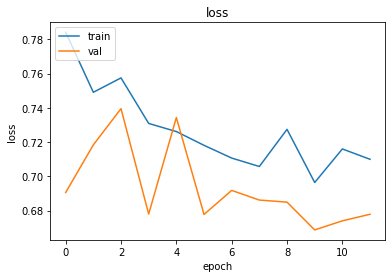

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 76)
pool shape: (None, 1, 76)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 1, 19, 4)     0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 10, 76)    3040        zero_padding2d_1[0][0]  

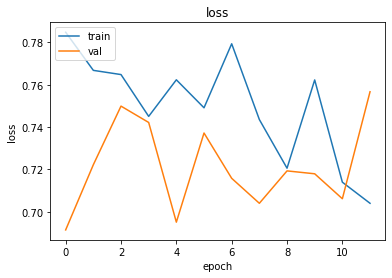

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 76)
pool shape: (None, 1, 76)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 1, 19, 4)     0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 10, 76)    3040        zero_padding2d_2[0][0]  

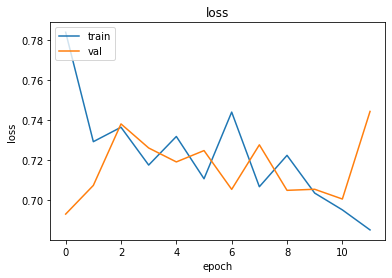

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 76)
pool shape: (None, 1, 76)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 1, 19, 4)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1, 10, 76)    3040        zero_padding2d_3[0][0]  

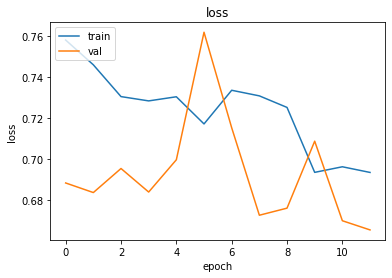

13408
avg_AUC :  0.6026196997936614
avg_AUC_2 :  0.6026998750545695
         0         1         2   ...        9         10        11
0  0.595029  0.520234  0.621616  ...  0.623291  0.629652  0.631363
1  0.564114  0.562525  0.574714  ...  0.585180  0.560228  0.586187
2  0.535167  0.547742  0.545477  ...  0.562271  0.576165  0.575407
3  0.583172  0.623487  0.615093  ...  0.611323  0.611440  0.617786

[4 rows x 12 columns]
0     0.569370
1     0.563497
2     0.589225
3     0.595390
4     0.587843
5     0.585475
6     0.581493
7     0.592765
8     0.574414
9     0.595516
10    0.594371
11    0.602686
dtype: float64


In [ ]:
#use model model_tcn
# T=1, 
# variables: Overall Similarity + Word Changes
w = 1
perf_cols =  v_1 
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w1_v1words',w, \
          filters = 76)


 ======= v_1 and word changes =========
init A shape:  (53635, 56)
(53635, 1, 15) (53635, 1, 10, 4) 487.0
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 36)
pool shape: (None, 1, 36)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 1, 19, 4)     0           batch_normalization_39[0][0]     
_______________________________________________________________________________________

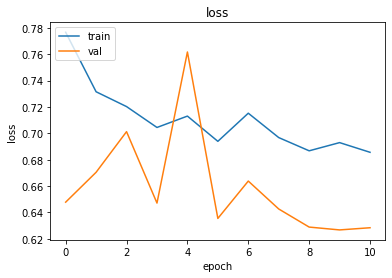

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 36)
pool shape: (None, 1, 36)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 1, 19, 4)     0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 1, 10, 36)    1440        zero_padding2d_14[0][0] 

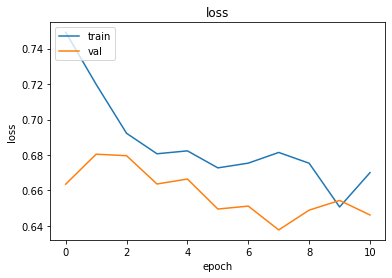

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 36)
pool shape: (None, 1, 36)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 1, 19, 4)     0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 1, 10, 36)    1440        zero_padding2d_15[0][0] 

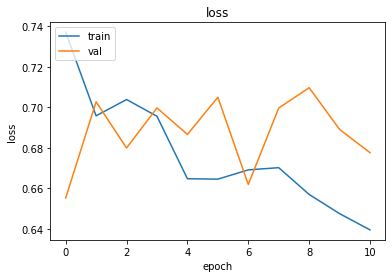

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 36)
pool shape: (None, 1, 36)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 1, 19, 4)     0           batch_normalization_48[0][0]     
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 1, 10, 36)    1440        zero_padding2d_16[0][0] 

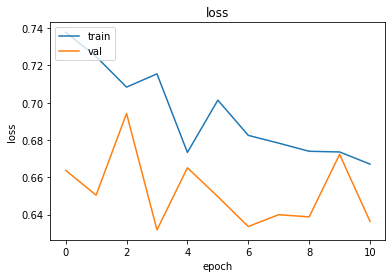

13408
avg_AUC :  0.6991012624716983
avg_AUC_2 :  0.6989853486771248
         0         1         2   ...        8         9         10
0  0.682982  0.647984  0.696384  ...  0.713123  0.714088  0.713145
1  0.637712  0.701869  0.689468  ...  0.698540  0.714728  0.699680
2  0.670678  0.668495  0.671268  ...  0.673243  0.675342  0.678514
3  0.636284  0.672244  0.673760  ...  0.713296  0.697728  0.706527

[4 rows x 11 columns]
0     0.656914
1     0.672648
2     0.682720
3     0.692741
4     0.694959
5     0.695123
6     0.700167
7     0.698551
8     0.699550
9     0.700472
10    0.699467
dtype: float64


In [ ]:


#use model model_tcn
# T=1, 
# variables: Quant. Indicators + Overall Similarity + Word Changes
w = 1
perf_cols =  v_1 + v_perf
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w1_v1words',w, \
          filters = 36)


init A shape:  (53635, 83)
(45945, 2, 1) (45945, 2, 10, 4) 408.0
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_4 (Conv2D)             

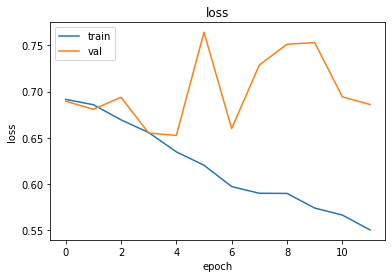

11487
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 2, 10, 56)    2240        zero_padding2d_5[0][0]  

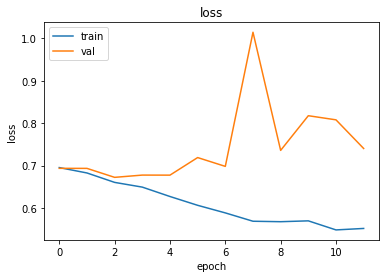

11486
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 2, 10, 56)    2240        zero_padding2d_6[0][0]  

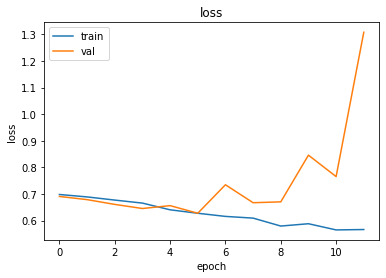

11486
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 10, 56)    2240        zero_padding2d_7[0][0]  

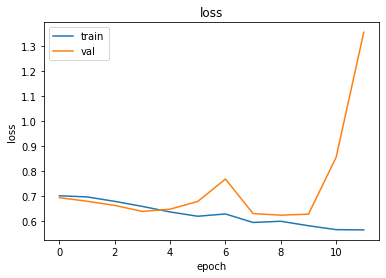

11486
avg_AUC :  0.6742836276248698
avg_AUC_2 :  0.6740443652208358
         0         1         2   ...        9         10        11
0  0.625916  0.634127  0.649667  ...  0.683061  0.677392  0.683538
1  0.545206  0.573402  0.626816  ...  0.663497  0.676249  0.681581
2  0.589360  0.623480  0.667025  ...  0.699693  0.711343  0.645997
3  0.581393  0.629218  0.674525  ...  0.729153  0.717093  0.670649

[4 rows x 12 columns]
0     0.585469
1     0.615057
2     0.654508
3     0.669816
4     0.677680
5     0.674051
6     0.682181
7     0.683273
8     0.687961
9     0.693851
10    0.695519
11    0.670441
dtype: float64


In [ ]:
#use model model_tcn_1
# T=2 
# variables: Overall Similarity + Word Changes


w = 2
perf_cols =  v_1
words_cols = selected_new_all_sorted
label = 'label'
h2 = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w2_v1words',w, \
          filters = 56)

init A shape:  (53635, 111)
(45945, 2, 15) (45945, 2, 10, 4) 408.0
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_4 (Conv2D)           

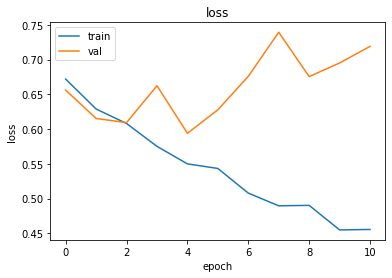

11487
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 2, 10, 56)    2240        zero_padding2d_5[0][0]  

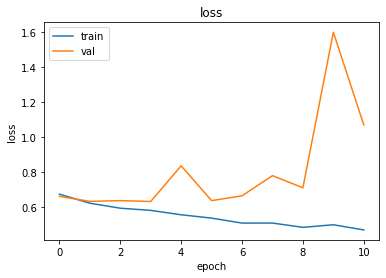

11486
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 2, 10, 56)    2240        zero_padding2d_6[0][0]  

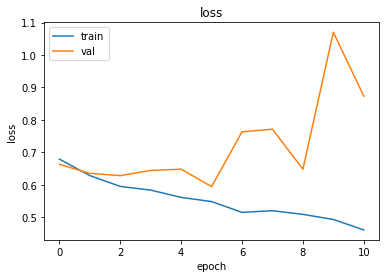

11486
shape after padding: (None, 2, 19, 4)
conv shape: (None, 2, 10, 56)
pool shape: (None, 2, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 2, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 2, 19, 4)     0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 10, 56)    2240        zero_padding2d_7[0][0]  

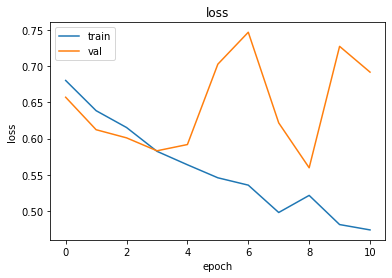

11486
avg_AUC :  0.7648338681771099
avg_AUC_2 :  0.7645944741532976
         0         1         2   ...        8         9         10
0  0.709285  0.740016  0.751786  ...  0.735761  0.758147  0.759324
1  0.669359  0.701409  0.719054  ...  0.736948  0.700120  0.743380
2  0.704693  0.721463  0.733070  ...  0.772068  0.736528  0.761724
3  0.685467  0.731847  0.754639  ...  0.775447  0.788359  0.786363

[4 rows x 11 columns]
0     0.692201
1     0.723684
2     0.739637
3     0.745149
4     0.743818
5     0.750098
6     0.749306
7     0.751123
8     0.755056
9     0.745788
10    0.762698
dtype: float64


In [ ]:

#use model model_tcn_1
# T=2 
# variables: Quant. Indicators + Overall Similarity + Word Changes
w = 2
perf_cols =  v_1 + v_perf
words_cols = selected_new_all_sorted
label = 'label'
h2 = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w2',w, \
          filters = 56)

init A shape:  (53635, 124)
(39123, 3, 1) (39123, 3, 10, 4) 341.0
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_48[0][0]     
__________________________________________________________________________________________________
conv2d_16 (Conv2D)           

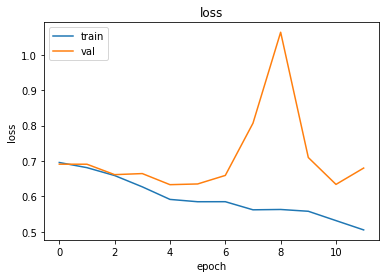

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 3, 10, 56)    2240        zero_padding2d_17[0][0]  

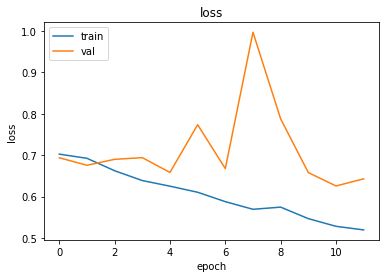

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_54[0][0]     
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 3, 10, 56)    2240        zero_padding2d_18[0][0]  

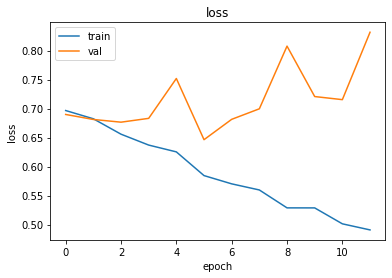

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_57[0][0]     
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 3, 10, 56)    2240        zero_padding2d_19[0][0]  

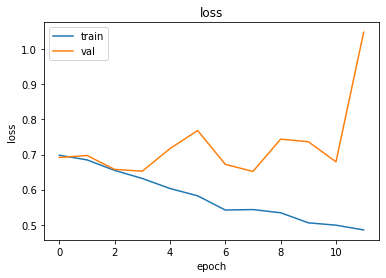

9780
avg_AUC :  0.7339410428194508
avg_AUC_2 :  0.7338774198897319
         0         1         2   ...        9         10        11
0  0.602736  0.636010  0.655658  ...  0.724671  0.737073  0.740095
1  0.579264  0.615373  0.672499  ...  0.738125  0.739119  0.760645
2  0.572446  0.608430  0.649635  ...  0.699858  0.700107  0.738878
3  0.555012  0.608200  0.665089  ...  0.699174  0.705782  0.695020

[4 rows x 12 columns]
0     0.577365
1     0.617003
2     0.660720
3     0.669930
4     0.683131
5     0.694935
6     0.701053
7     0.705972
8     0.690126
9     0.715457
10    0.720520
11    0.733660
dtype: float64


In [ ]:
#use model model_tcn_1
# T=3 
# variables: Overall Similarity + Word Changes

w = 3 
perf_cols =  v_1
words_cols = selected_new_all_sorted
label = 'label'
h3 = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w3_v1words',w, \
          filters = 56)

init A shape:  (53635, 166)
(39123, 3, 15) (39123, 3, 10, 4) 341.0
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 3, 19, 4)     0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)             

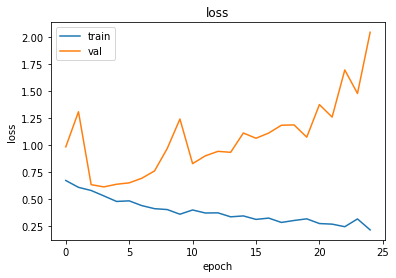

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 19, 4)     0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 10, 56)    2240        zero_padding2d_1[0][0]   

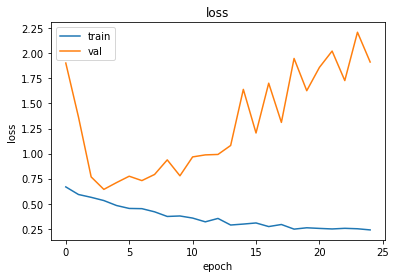

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 3, 19, 4)     0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 10, 56)    2240        zero_padding2d_2[0][0]   

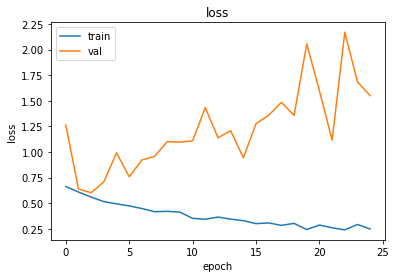

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 3, 19, 4)     0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 10, 56)    2240        zero_padding2d_3[0][0]   

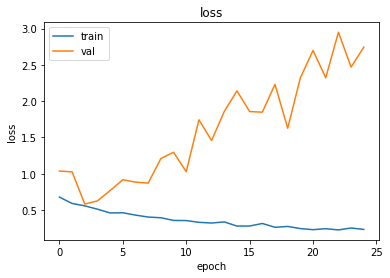

9780
avg_AUC :  0.8269309921510855
avg_AUC_2 :  0.8264239522447457
         0         1         2   ...        22        23        24
0  0.694964  0.679960  0.773491  ...  0.802538  0.829609  0.790063
1  0.658475  0.683398  0.754061  ...  0.816075  0.765384  0.797470
2  0.671528  0.721011  0.779042  ...  0.757241  0.760237  0.797727
3  0.677293  0.725000  0.776963  ...  0.709763  0.735977  0.707271

[4 rows x 25 columns]
0     0.675565
1     0.702342
2     0.770889
3     0.785628
4     0.772164
5     0.789257
6     0.791522
7     0.791527
8     0.786930
9     0.782742
10    0.806781
11    0.780779
12    0.794181
13    0.796499
14    0.782887
15    0.795481
16    0.790376
17    0.781016
18    0.795253
19    0.792339
20    0.773828
21    0.791711
22    0.771404
23    0.772802
24    0.773133
dtype: float64


In [34]:

#use model model_tcn_1
# T=3 
# variables: Quant. Indicators + Overall Similarity + Word Changes
w = 3
perf_cols =  v_1 + v_perf
words_cols = selected_new_all_sorted
label = 'label'
h3 = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w3',w, \
          filters = 56)

In [ ]:
mean_fpr = np.linspace(0,1,100)

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Quant. Indicators + Overall Change + Word Change: ROC Curve')

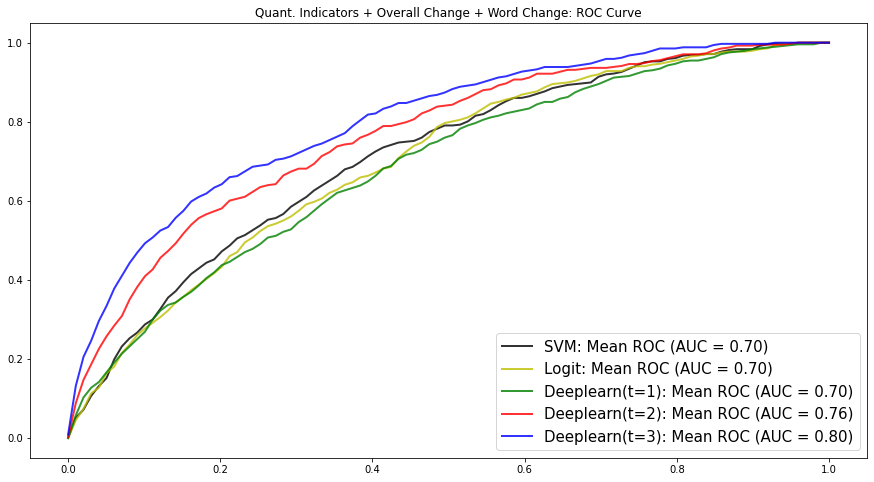

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(mean_fpr,mean_tpr_dict_svm['perf+spc+wrd'], color='k',
         label=r'SVM: Mean ROC (AUC = %0.2f)' % (0.7040),
         lw=2, alpha=.8)
plt.plot(mean_fpr,mean_tpr_dict_lg['perf+spc+wrd'], color='y',
         label=r'Logit: Mean ROC (AUC = %0.2f)' % (0.6977),
         lw=2, alpha=.8)
# plt.plot(mean_fpr,mean_tpr_dict_nn['perf+spc+wrd'], color='r',
#          label=r'NeuralNet: Mean ROC (AUC = %0.2f)' % (0.708418330709835),
#          lw=2, alpha=.8)
plt.plot(mean_fpr,h[1], color='g',
         label=r'Deeplearn(t=1): Mean ROC (AUC = %0.2f)' % (0.7049),
         lw=2, alpha=.8)
plt.plot(mean_fpr,h2[1], color='r',
         label=r'Deeplearn(t=2): Mean ROC (AUC = %0.2f)' % (0.7550),
         lw=2, alpha=.8)
plt.plot(mean_fpr,h3[1], color='b',
         label=r'Deeplearn(t=3): Mean ROC (AUC = %0.2f)' % (0.8042),
         lw=2, alpha=.8)
plt.legend(loc="lower right", prop={'size': 15})
plt.title('Quant. Indicators + Overall Change + Word Change: ROC Curve')
plt.show()

# calculate the predicted proba

In [ ]:
from sklearn.isotonic import IsotonicRegression
import random

In [ ]:
target_data = df_fl[df_fl.cik == 56873]

In [ ]:
target_index = list(target_data.index)

In [ ]:
df_fl_1 = df_fl.drop(target_index)

In [ ]:
fraud_cik = list(set(df_fl_1[df_fl_1.label == 1].cik))
non_fraud_cik = list(set(df_fl_1[df_fl_1.label == 0].cik))

In [ ]:
fraud_cik_1 = random.choices(fraud_cik,k = 25)
non_fraud_cik_1 = random.choices(non_fraud_cik, k =25)

In [ ]:
selected_cik = fraud_cik_1 + non_fraud_cik_1

In [ ]:
test_data = df_fl_1[df_fl_1.cik.isin(selected_cik)]

In [ ]:
test_data.shape

(367, 212)

In [ ]:
train_data = df_fl_1[~df_fl_1.cik.isin(selected_cik)]

In [ ]:
train_data.shape

(53251, 212)

In [ ]:
train_data[train_data.cik == 56873]

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down


In [ ]:
test_data[test_data.cik == 56873]

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down


In [ ]:
train_x = train_data[v_perf +v_1 +selected_new_all]
train_y = train_data['label']
test_x = test_data[v_perf +v_1 +selected_new_all]
test_y = test_data['label']

In [ ]:
svm = LinearSVC(class_weight = {0:1, 1:200})
svm.fit(train_x, train_y)
pickle.dump(svm, open('svm_fordisplay', 'wb'))
decision_values = svm.decision_function(test_x)
auc_score_svm = roc_auc_score(test_y, decision_values)
print(auc_score_svm)

LinearSVC(C=1.0, class_weight={0: 1, 1: 200}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

0.7377698667891593


In [ ]:
prob_target = svm.decision_function(target_data[v_perf +v_1 +selected_new_all])

In [ ]:
prob_target

array([-0.56175935, -0.41649336, -0.67245259, -0.36471707, -0.17145531,
       -0.54259997, -0.85336318, -0.62310378, -0.8858555 , -1.03192812,
       -1.02311428, -1.31782147, -0.82593878, -0.80730556, -1.01182286,
       -1.19717493, -1.12341224])

In [ ]:
lg = LogisticRegression(class_weight = {0:1, 1:200})
lg.fit(decision_values.reshape(-1,1),test_y)
op_list_svm_t_lg = lg.predict_proba(prob_target.reshape(-1,1))

LogisticRegression(C=1.0, class_weight={0: 1, 1: 200}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
op_list_svm_t_lg

array([[0.04123083, 0.95876917],
       [0.0270635 , 0.9729365 ],
       [0.05654655, 0.94345345],
       [0.02326158, 0.97673842],
       [0.01316385, 0.98683615],
       [0.03901828, 0.96098172],
       [0.09347607, 0.90652393],
       [0.04914972, 0.95085028],
       [0.1020672 , 0.8979328 ],
       [0.14977385, 0.85022615],
       [0.14643882, 0.85356118],
       [0.29339541, 0.70660459],
       [0.08673562, 0.91326438],
       [0.08241   , 0.91759   ],
       [0.14225645, 0.85774355],
       [0.22429984, 0.77570016],
       [0.18816088, 0.81183912]])

In [ ]:
ir = IsotonicRegression()
ir.fit(decision_values,test_y)
op_list_svm_t_ir = ir.predict(prob_target)

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

In [ ]:
op_list_svm_t_ir

array([0.10344828, 0.12765957, 0.07936508, 0.21333333, 0.25      ,
       0.10344828, 0.06818182, 0.07936508, 0.06818182, 0.        ,
       0.        , 0.        , 0.06818182, 0.06818182, 0.        ,
       0.        , 0.        ])

init A shape:  (53635, 166)
(39123, 3, 15) (39123, 3, 10, 4) 341.0
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 3, 19, 4)     0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)             

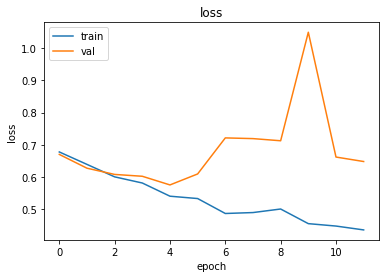

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 19, 4)     0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 10, 56)    2240        zero_padding2d_1[0][0]   

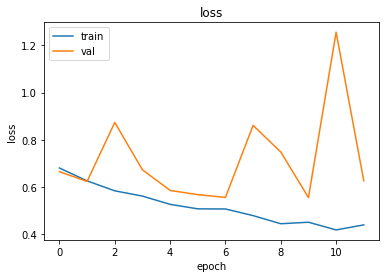

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 3, 19, 4)     0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 10, 56)    2240        zero_padding2d_2[0][0]   

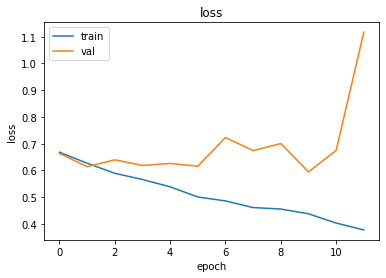

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 56)
pool shape: (None, 3, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 3, 19, 4)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 10, 56)    2240        zero_padding2d_3[0][0]   

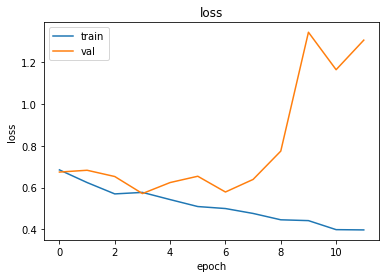

9780
avg_AUC :  0.7879416936304351
avg_AUC_2 :  0.7876400806975362
         0         1         2   ...        9         10        11
0  0.710842  0.740732  0.759553  ...  0.768802  0.790354  0.786254
1  0.701399  0.720076  0.760847  ...  0.816044  0.790214  0.807507
2  0.683563  0.729587  0.759801  ...  0.807370  0.805988  0.792528
3  0.702318  0.704526  0.745001  ...  0.734399  0.748603  0.738467

[4 rows x 12 columns]
0     0.699530
1     0.723730
2     0.756301
3     0.762140
4     0.761482
5     0.779285
6     0.779202
7     0.790093
8     0.779418
9     0.781654
10    0.783790
11    0.781189
dtype: float64


In [ ]:
w = 3
perf_cols =  v_1 + v_perf
words_cols = selected_new_all_sorted
label = 'label'
h3_t = cross_val(train_data, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w3_fordisplay',w, \
          filters = 56)

In [ ]:
from keras.models import load_model

In [ ]:
model_dl = load_model('model_tcn_w3_fordisplay_3.h5')

In [ ]:
A_perf_test, A_words_test, Y_test = shift_data(test_data, 3, v_perf+v_1, selected_new_all_sorted, 'label')
A_perf_t, A_words_t, Y_t = shift_data(target_data, 3, v_perf+v_1, selected_new_all_sorted, 'label')

init A shape:  (367, 166)
(274, 3, 15) (274, 3, 10, 4) 38.0
init A shape:  (17, 166)
(15, 3, 15) (15, 3, 10, 4) 2.0


In [ ]:
op_list_dl_test = model_dl.predict([A_perf_test, A_words_test])
#lop_list_dl = op_list_dl[:,0]

op_list_dl_t = model_dl.predict([A_perf_t, A_words_t])
#op_list_dl_t = op_list_dl_t[:,0]

In [ ]:
ir = IsotonicRegression()
ir.fit(op_list_dl_test[:,0],Y_test)
op_list_dl_t_ir = ir.predict(op_list_dl_t[:,0])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

In [ ]:
op_list_dl_t_ir = [None, None] + op_list_dl_t_ir.tolist()

In [ ]:
lg = LogisticRegression(class_weight = {0:1, 1:200})
lg.fit(op_list_dl_test,Y_test)
op_list_dl_t_lg = lg.predict_proba(op_list_dl_t)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 200}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
op_list_dl_t_lg[:,1] 

array([0.96987632, 0.96987688, 0.96986869, 0.969862  , 0.96986524,
       0.96986278, 0.96985983, 0.96985873, 0.96985821, 0.96985809,
       0.96985839, 0.96985878, 0.96985887, 0.96985932, 0.96985865])

In [ ]:
target_data.y2

4485    1996.0
4486    1997.0
4487    1998.0
4488    1999.0
4489    2000.0
4490    2001.0
4491    2002.0
4492    2003.0
4493    2004.0
4494    2005.0
4495    2006.0
4496    2007.0
4497    2008.0
4498    2009.0
4499    2010.0
4500    2011.0
4501    2012.0
Name: y2, dtype: float64

In [ ]:
target_data.y1

4485    1995.0
4486    1996.0
4487    1997.0
4488    1998.0
4489    1999.0
4490    2000.0
4491    2001.0
4492    2002.0
4493    2003.0
4494    2004.0
4495    2005.0
4496    2006.0
4497    2007.0
4498    2008.0
4499    2009.0
4500    2010.0
4501    2011.0
Name: y1, dtype: float64

In [ ]:
target_res_tb = pd.DataFrame({'year':target_data.y2, 's1':target_data.s1, 'svm':op_list_svm_t_ir, 'dl':op_list_dl_t_ir} )

In [ ]:
target_res_tb.to_csv('target_res_tb_fordisplay.csv',index = False)

Text(0, 0.5, 'Overall Similarity')

Text(0, 0.5, 'Overall Similarity')

Text(0, 0.5, 'Predicted Proba')

Text(0, 0.5, 'Predicted Proba')

Text(0.5, 1.0, 'Prediction Result of SVM')

Text(0.5, 1.0, 'Prediction Result of DeepLearning')

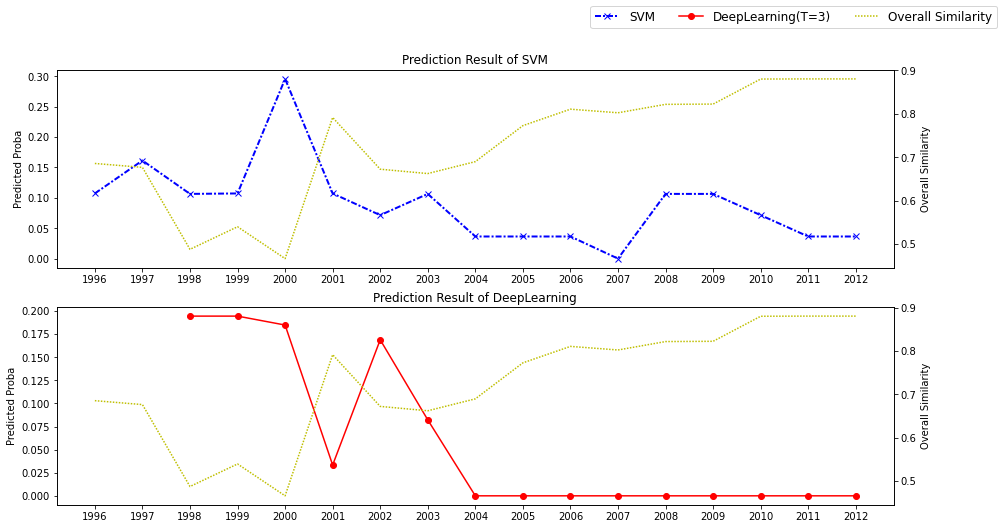

In [ ]:
fig, ax1 = plt.subplots(2)
fig.set_figwidth(15)
fig.set_figheight(8)

fontP = FontProperties()
fontP.set_size('large')

ax2 = ax1[0].twinx()
ax3 = ax1[1].twinx()
#ax4 = ax1.twinx()

#ax3.spines['right'].set_position(('outward', 60))
#ax4.spines['right'].set_position(('outward', 60))

ax2.plot(target_data.y2, target_data.s1, linestyle=(0, (1, 1)), c= 'y' , label = 'Overall Similarity')
ax3.plot(target_data.y2, target_data.s1, linestyle=(0, (1, 1)), c= 'y' ) #
ax1[0].plot(target_data.y2, op_list_svm_t_ir, marker='x', linewidth=2.0, c = 'b', linestyle=(0, (3, 1, 1, 1)), label = 'SVM')
#ax2.plot(target_data.y2, op_list_lg_t, linewidth=2.0,marker='.', c = 'g', linestyle=(0, (3, 1, 1, 1, 1, 1)), label = 'LogitReg')
#ax3.plot(target_data.y2, op_list_dl2, c= 'm' , marker='x', linestyle=(0, (5, 1)), label = 'DeepLearning(T=2)')
ax1[1].plot(target_data.y2, op_list_dl_t_ir, c= 'r' , marker='o', label = 'DeepLearning(T=3)')
ax2.set_ylabel('Overall Similarity')
ax3.set_ylabel('Overall Similarity')
ax1[0].set_ylabel('Predicted Proba')
ax1[1].set_ylabel('Predicted Proba')
#ax3.set_ylabel('Predicted Proba of Deeplearning(T=2)')
#ax4.set_ylabel('Predicted Proba for Deeplearning(T=3)')

#lt.xticks(mean_s_tb.index)
# ax1.plot(tbtb_temp.y2, temp_tb.nn_proba, linewidth=2.0, c = 'b',label = 'neualnet')
# ax2.plot(temp_tb.y2, temp_tb.s1, linewidth=2.0, c = 'g',label = 'overall similarity')
fig.legend(loc="best", prop=fontP,  ncol=5)
# ax1.set_ylabel('similarity score for fraud case')
# ax2.set_ylabel('similarity score for avg. overall similarity')

#ax1.scatter(target_data[target_data.label == 1].y2, target_data[target_data.label == 1].s1, c = 'r')
# ax1.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].nn_proba, c = 'b')
# ax2.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].s1, c = 'g')
ax1[0].set_xticks(target_data.y2)
ax1[1].set_xticks(target_data.y2)
ax1[0].set_title('Prediction Result of SVM')
ax1[1].set_title('Prediction Result of DeepLearning')
# ax1[0].set_xticklabels(target_data.y2)
# ax1[1].set_xticklabels(target_data.y2)

In [ ]:
target_wrds = target_data[v_1 +selected_new_all_sorted + ['y2']]

In [ ]:
target_wrds

,s1,WeakModal_3_p,WeakModal_3_new,WeakModal_3_n,WeakModal_3_dis,Negative_3_p,Negative_3_new,Negative_3_n,Negative_3_dis,Compare_3_p,Compare_3_new,Compare_3_n,Compare_3_dis,Discrep_3_p,Discrep_3_new,Discrep_3_n,Discrep_3_dis,Positive_3_p,Positive_3_new,Positive_3_n,Positive_3_dis,Achieve_3_p,Achieve_3_new,Achieve_3_n,Achieve_3_dis,Reward_3_p,Reward_3_new,Reward_3_n,Reward_3_dis,StrongModal_3_p,StrongModal_3_new,StrongModal_3_n,StrongModal_3_dis,Uncertainty_3_p,Uncertainty_3_new,Uncertainty_3_n,Uncertainty_3_dis,Litigious_3_p,Litigious_3_new,Litigious_3_n,Litigious_3_dis,y2
4485,0.685423,0.000000,0.001299,0.103448,0.000000,0.068966,0.011660,0.241379,0.010024,0.172414,0.005766,0.344828,0.019583,0.103448,0.014161,0.275862,0.000000,0.103448,0.024609,0.206897,0.020874,0.068966,0.006884,0.275862,0.011621,0.103448,0.013141,0.068966,0.003131,0.034483,0.004167,0.137931,0.005760,0.137931,0.013798,0.103448,0.003607,0.068966,0.008511,0.034483,0.002315,1996.0
4486,0.676390,0.115385,0.016012,0.038462,0.000000,0.153846,0.026925,0.192308,0.000946,0.307692,0.010333,0.307692,0.008362,0.192308,0.024908,0.153846,0.014024,0.230769,0.011702,0.192308,0.006273,0.192308,0.011771,0.269231,0.005198,0.307692,0.007184,0.076923,0.008791,0.076923,0.000000,0.115385,0.002976,0.269231,0.036907,0.076923,0.008008,0.076923,0.002941,0.076923,0.001276,1997.0
4487,0.487491,0.150000,0.000000,0.150000,0.000000,0.100000,0.019759,0.100000,0.004160,0.300000,0.019382,0.300000,0.009165,0.200000,0.004969,0.150000,0.007085,0.150000,0.004999,0.250000,0.019012,0.200000,0.013173,0.250000,0.013321,0.150000,0.003899,0.250000,0.012928,0.050000,0.004109,0.000000,0.002331,0.050000,0.002833,0.300000,0.014648,0.100000,0.005702,0.150000,0.000905,1998.0
4488,0.539512,0.050000,0.004903,0.100000,0.007860,0.200000,0.009721,0.300000,0.032157,0.300000,0.023072,0.200000,0.016841,0.100000,0.007374,0.200000,0.018487,0.150000,0.007330,0.250000,0.005807,0.200000,0.010671,0.200000,0.018225,0.150000,0.004878,0.200000,0.006290,0.050000,0.002358,0.150000,0.002833,0.150000,0.010906,0.150000,0.016978,0.150000,0.002212,0.200000,0.007789,1999.0
4489,0.466077,0.136364,0.017117,0.113636,0.002516,0.113636,0.023459,0.068182,0.011975,0.181818,0.010453,0.272727,0.024181,0.181818,0.011101,0.090909,0.005005,0.090909,0.009102,0.113636,0.008258,0.250000,0.010423,0.090909,0.006771,0.090909,0.011072,0.136364,0.004056,0.000000,0.003338,0.045455,0.000851,0.159091,0.040863,0.159091,0.004528,0.022727,0.003281,0.090909,0.001563,2000.0
4490,0.791387,0.068182,0.004020,0.090909,0.000000,0.136364,0.016921,0.068182,0.019512,0.204545,0.019725,0.181818,0.025758,0.022727,0.008379,0.181818,0.000000,0.045455,0.004791,0.045455,0.004545,0.113636,0.009300,0.136364,0.019788,0.090909,0.006124,0.022727,0.002273,0.000000,0.008041,0.045455,0.000000,0.113636,0.018680,0.159091,0.006897,0.045455,0.008745,0.068182,0.000000,2001.0
4491,0.672189,0.094118,0.003907,0.105882,0.003529,0.152941,0.011706,0.247059,0.010135,0.200000,0.022230,0.223529,0.020088,0.117647,0.008858,0.164706,0.008669,0.094118,0.007699,0.152941,0.012503,0.152941,0.015819,0.258824,0.005461,0.152941,0.010214,0.141176,0.006417,0.082353,0.006177,0.152941,0.000000,0.176471,0.016009,0.235294,0.012260,0.082353,0.001664,0.129412,0.005372,2002.0
4492,0.662140,0.017544,0.001807,0.078947,0.006464,0.219298,0.021735,0.114035,0.011177,0.254386,0.026550,0.175439,0.021516,0.114035,0.007649,0.140351,0.008264,0.157895,0.010046,0.078947,0.006331,0.157895,0.012198,0.175439,0.013948,0.140351,0.008560,0.114035,0.007254,0.078947,0.003243,0.070175,0.005002,0.114035,0.008735,0.210526,0.016892,0.026316,0.003976,0.070175,0.004264,2003.0
4493,0.689602,0.068966,0.005626,0.041379,0.001283,0.124138,0.013446,0.131034,0.016635,0.193103,0.022242,0.124138,0.029753,0.124138,0.014216,0.075862,0.005706,0.096552,0.019142,0.089655,0.012830,0.110345,0.012009,0.151724,0.013237,0.062069,0.006507,0.131034,0.010446,0.055172,0.006597,0.075862,0.003522,0.110345,0.015218,0.096552,0.008781,0.068966,0.008582,0.034483,0.003719

Text(0, 0.5, 'Deleted Content with Weak Modal')

Text(0, 0.5, 'Added Content with Weak Modal')

Text(0, 0.5, 'Increased Content with Comparision')

Text(0, 0.5, 'Decreased Content with Comparison')

Text(0, 0.5, 'Added Content with Positive')

Text(0, 0.5, 'Added Content with Negative')

No handles with labels found to put in legend.


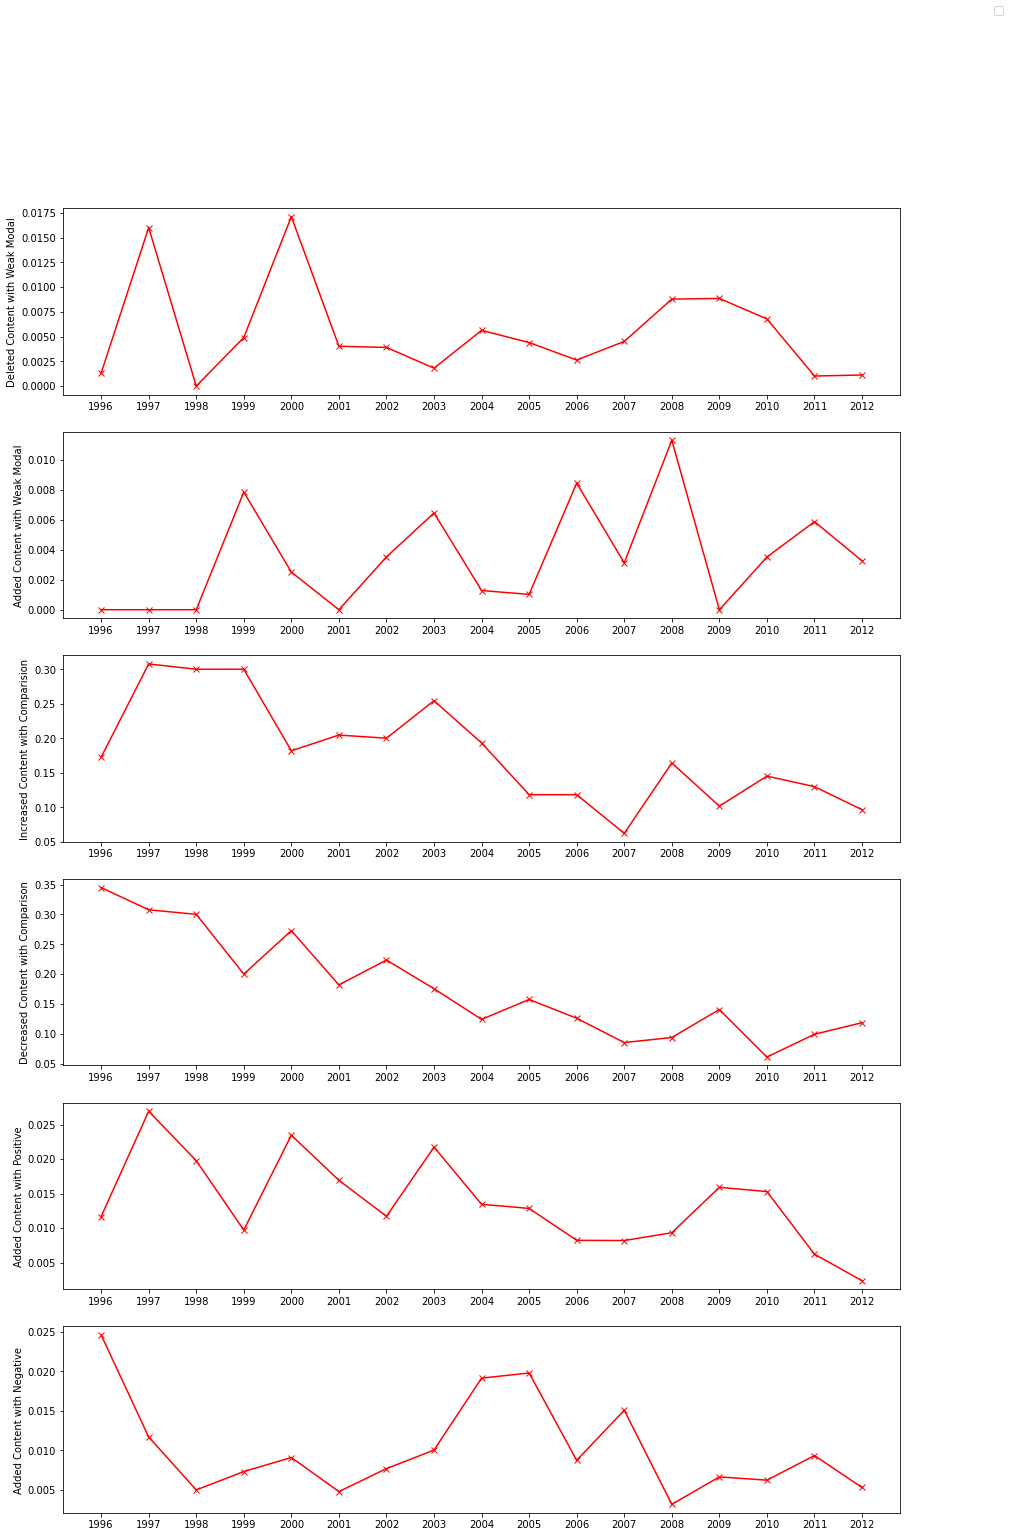

In [ ]:
fig, ax1 = plt.subplots(6)
fig.set_figwidth(15)
fig.set_figheight(24)

fontP = FontProperties()
fontP.set_size('large')

#ax2 = ax1[0].twinx()
#ax3 = ax1[1].twinx()
#ax4 = ax1.twinx()

#ax3.spines['right'].set_position(('outward', 60))
#ax4.spines['right'].set_position(('outward', 60))

#ax2.plot(target_wrds.y2, target_wrds.s1, linestyle=(0, (1, 1)), c= 'y' , label = 'Overall Similarity')
#ax3.plot(target_wrds.y2, target_wrds.s1, linestyle=(0, (1, 1)), c= 'y' ) #
ax1[0].plot(target_wrds.y2, target_wrds.WeakModal_3_new, marker='x', c = 'r')
#ax2.plot(target_data.y2, op_list_lg_t, linewidth=2.0,marker='.', c = 'g', linestyle=(0, (3, 1, 1, 1, 1, 1)), label = 'LogitReg')
#ax3.plot(target_data.y2, op_list_dl2, c= 'm' , marker='x', linestyle=(0, (5, 1)), label = 'DeepLearning(T=2)')
ax1[1].plot(target_wrds.y2, target_wrds.WeakModal_3_dis, c= 'r' , marker='x')
ax1[2].plot(target_wrds.y2, target_wrds.Compare_3_p, c= 'r' , marker='x')
ax1[3].plot(target_wrds.y2, target_wrds.Compare_3_n, c= 'r' , marker='x')
ax1[4].plot(target_wrds.y2, target_wrds.Negative_3_new, c= 'r' , marker='x')
ax1[5].plot(target_wrds.y2, target_wrds.Positive_3_new, c= 'r' , marker='x')
#ax2.set_ylabel('Overall Similarity')
#ax3.set_ylabel('Overall Similarity')
ax1[0].set_ylabel('Deleted Content with Weak Modal')
ax1[1].set_ylabel('Added Content with Weak Modal')
ax1[2].set_ylabel('Increased Content with Comparision')
ax1[3].set_ylabel('Decreased Content with Comparison')
ax1[4].set_ylabel('Added Content with Positive')
ax1[5].set_ylabel('Added Content with Negative')
#ax3.set_ylabel('Predicted Proba of Deeplearning(T=2)')
#ax4.set_ylabel('Predicted Proba for Deeplearning(T=3)')

#lt.xticks(mean_s_tb.index)
# ax1.plot(tbtb_temp.y2, temp_tb.nn_proba, linewidth=2.0, c = 'b',label = 'neualnet')
# ax2.plot(temp_tb.y2, temp_tb.s1, linewidth=2.0, c = 'g',label = 'overall similarity')
fig.legend(loc="best", prop=fontP,  ncol=5)
# ax1.set_ylabel('similarity score for fraud case')
# ax2.set_ylabel('similarity score for avg. overall similarity')

#ax1.scatter(target_data[target_data.label == 1].y2, target_data[target_data.label == 1].s1, c = 'r')
# ax1.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].nn_proba, c = 'b')
# ax2.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].s1, c = 'g')
ax1[0].set_xticks(target_wrds.y2)
ax1[1].set_xticks(target_wrds.y2)
ax1[2].set_xticks(target_wrds.y2)
ax1[3].set_xticks(target_wrds.y2)
ax1[4].set_xticks(target_wrds.y2)
ax1[5].set_xticks(target_wrds.y2)
# ax1[0].set_title('Prediction Result of SVM')
# ax1[1].set_title('Prediction Result of DeepLearning')
# ax1[0].set_xticklabels(target_data.y2)
# ax1[1].set_xticklabels(target_data.y2)

Text(0, 0.5, 'Overall Similarity')

Text(0, 0.5, 'Predicted Proba')

([<matplotlib.axis.XTick at 0x7fdce0384590>,
 <a list of 17 Text major ticklabel objects>)

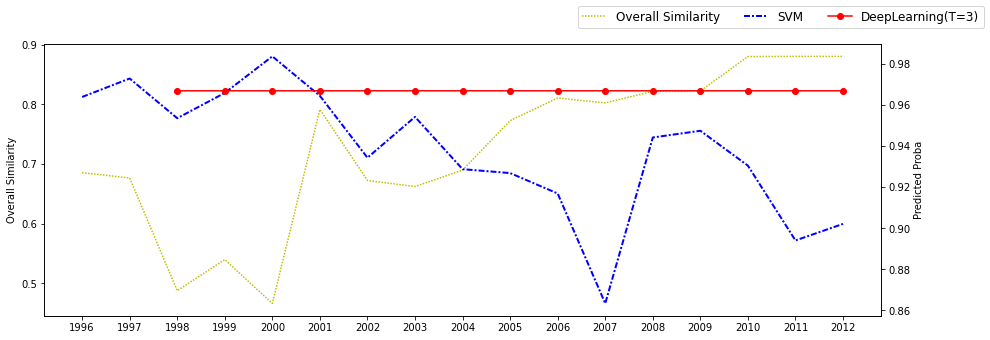

In [ ]:
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

fontP = FontProperties()
fontP.set_size('large')

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax4 = ax1.twinx()

#ax3.spines['right'].set_position(('outward', 60))
#ax4.spines['right'].set_position(('outward', 60))

ax1.plot(target_data.y2, target_data.s1, linestyle=(0, (1, 1)), c= 'y' , label = 'Overall Similarity') #
ax2.plot(target_data.y2, op_list_svm_t_lg[:,1], linewidth=2.0, c = 'b', linestyle=(0, (3, 1, 1, 1)), label = 'SVM')
#ax2.plot(target_data.y2, op_list_lg_t, linewidth=2.0,marker='.', c = 'g', linestyle=(0, (3, 1, 1, 1, 1, 1)), label = 'LogitReg')
#ax3.plot(target_data.y2, op_list_dl2, c= 'm' , marker='x', linestyle=(0, (5, 1)), label = 'DeepLearning(T=2)')
ax2.plot(target_data.y2, [None,None] + op_list_dl_t_lg[:,1].tolist() , c= 'r' , marker='o', label = 'DeepLearning(T=3)')
ax1.set_ylabel('Overall Similarity')
ax2.set_ylabel('Predicted Proba')
#ax3.set_ylabel('Predicted Proba of Deeplearning(T=2)')
#ax4.set_ylabel('Predicted Proba for Deeplearning(T=3)')

#lt.xticks(mean_s_tb.index)
# ax1.plot(tbtb_temp.y2, temp_tb.nn_proba, linewidth=2.0, c = 'b',label = 'neualnet')
# ax2.plot(temp_tb.y2, temp_tb.s1, linewidth=2.0, c = 'g',label = 'overall similarity')
fig.legend(loc="best", prop=fontP,  ncol=5)
# ax1.set_ylabel('similarity score for fraud case')
# ax2.set_ylabel('similarity score for avg. overall similarity')

#ax1.scatter(target_data[target_data.label == 1].y2, target_data[target_data.label == 1].s1, c = 'r')
# ax1.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].nn_proba, c = 'b')
# ax2.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].s1, c = 'g')

plt.xticks(target_data.y2)

In [ ]:
# ### SVM
loaded_model = pickle.load(open('svm_perf+spc+wrd_4', 'rb'))

prob = loaded_model.decision_function(data[v_perf +v_1 +selected_new_all])
prob_1 = loaded_model.decision_function(target_data[v_perf +v_1 +selected_new_all])

prob = prob.reshape(-1, 1)
prob_1 = prob_1.reshape(-1, 1)

ir = LogisticRegression(class_weight = {0:1, 1:200})
ir.fit(prob,data['label'])
op_list_svm_t = ir.predict_proba(prob_1)

# def convert_p(x):
#   r = 1/(1 + math.exp(-x))
#   return r


# op_list = []
# for p in prob:
#   op = convert_p(p)
#   op_list.append(op)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 200}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
prob

array([[-0.10902747],
       [ 0.10220726],
       [ 0.27376173],
       ...,
       [-0.60560191],
       [-0.40211444],
       [-0.40616745]])

In [ ]:
op_list_svm_t[:,1]

array([0.4971907 , 0.64878813, 0.63465469, 0.65758829, 0.82666658,
       0.56598724, 0.33879334, 0.51213757, 0.33127903, 0.2736542 ,
       0.29794971, 0.13874033, 0.40208689, 0.3893303 , 0.28820185,
       0.20863494, 0.2466696 ])

In [ ]:
op_list_svm_t

array([0.00607367, 0.00947368, 0.00970874, 0.00970874, 0.02838137,
       0.00607367, 0.0029164 , 0.00313589, 0.0029164 , 0.0029164 ,
       0.0029164 , 0.        , 0.0029164 , 0.0029164 , 0.00177117,
       0.00177117, 0.00177117])

In [ ]:
# def lg_3( data, vs, label, target_index):

#     data_1 = data.drop(target_index)

#     columns_fl = vs
#     data_target = data_1.loc[:,columns_fl + [label]]

#     #data for targeted individual
#     indiv_target = data.loc[target_index,columns_fl]

#     tprs = []
#     auc_list = []
#     mean_fpr = np.linspace(0,1,100)
    
#     class_report = []
#     sum_pred_list = []
#     kf = StratifiedKFold(n_splits = 4, shuffle = True)
#     c = 0
#     data_target = data[columns_fl + [label]]
#     data_target = data_target.dropna()
#     data_target = data_target.reset_index(drop = True)


#     tprs = []
#     auc_list = []
#     target_proba_list = []
#     mean_fpr = np.linspace(0,1,100)
    
#     class_report = []
#     sum_pred_list = []
#     kf = StratifiedKFold(n_splits = 4, shuffle = True)
#     c = 0
#     # data_target = data[columns_fl + [label]]
#     # data_target = data_target.dropna()
#     # data_target = data_target.reset_index(drop = True)
#     for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
#         c += 1

#         train_x = data_target.loc[train_index,columns_fl]
#         train_y = data_target.loc[train_index,label]
#         test_x = data_target.loc[test_index,columns_fl]
#         test_y = data_target.loc[test_index,label] 

#         print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
#         lg = LogisticRegression(class_weight = 'balanced')
#         lg.fit(train_x, train_y )
#         pickle.dump(lg, open('lg_'+str(vs[0])+ '_'+str(c), 'wb'))

#         pred = lg.predict(test_x)
#         sum_pred_list.append(pred)
#         print('sum of pred: ', sum(pred), '\n')
#         # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
#         # class_report.append(c_r)
#         #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
#         decision_values = lg.predict_proba(test_x)
#         auc_score = roc_auc_score(test_y, decision_values[:,1])
#         print(auc_score)
#         auc_list.append(auc_score)
#         fpr, tpr, thresholds = roc_curve(test_y, decision_values[:,1])
#         tprs.append(np.interp(mean_fpr, fpr, tpr))

#         clf_sigmoid = CalibratedClassifierCV(lg, cv=3, method='sigmoid')
#         clf_sigmoid.fit(train_x, train_y )
#         indiv_predict_proba = clf_sigmoid.predict_proba(indiv_target)[:, 1]
#         target_proba_list.append(indiv_predict_proba)
#         #print('AUC',auc_score)
        
#     mean_tpr = np.mean(tprs, axis=0)
#     print('avg_AUC : ', np.mean(auc_list))
#     print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
#     frauds_prec = []
#     fradus_recall = []
#     for d in class_report:
#         frauds_prec.append(d['1']['precision'])
#         fradus_recall.append(d['1']['recall'])
        
#     print('frauds_prec : ', np.mean(frauds_prec))
#     print('fradus_recall : ', np.mean(fradus_recall))
#     print('\n')

#     return np.mean(auc_list), mean_tpr, target_proba_list

In [ ]:
# _a, _b, target_proba_list =  lg_3(df_fl, v_perf +v_1 +selected_new_all, 'label', target_index)

iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  4513.0 

0.7034874467462958
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  4851.0 

0.7258203815636385
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  4712.0 

0.6772816274257966
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  4782.0 

0.6931742764785315
avg_AUC :  0.6999409330535656
avg_AUC_2 :  0.6999741008513533
frauds_prec :  nan
fradus_recall :  nan




In [ ]:
# target_proba_list[0]

array([0.01256771, 0.00852629, 0.00964477, 0.01262843, 0.0126376 ,
       0.00791638, 0.00573315, 0.00709556, 0.0054265 , 0.00523731,
       0.00439192, 0.00290963, 0.00442599, 0.00427527, 0.0035782 ,
       0.00416393, 0.00381549])

In [ ]:
###LG
loaded_mode_lg = pickle.load(open('lg_perf+spc+wrd_2', 'rb'))
op_list_lg = loaded_mode_lg.predict_proba(data[v_perf +v_1 +selected_new_all])
op_list_lg = op_list_lg[:,1]

In [ ]:
op_list_lg_t = loaded_mode_lg.predict_proba(target_data[v_perf +v_1 +selected_new_all])
op_list_lg_t = op_list_lg_t[:,1]

In [ ]:
ir = IsotonicRegression()
ir.fit(op_list_lg,data['label'])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

In [ ]:
op_list_lg_t = ir.predict(op_list_lg_t)

In [ ]:
### deep learning w = 3
from keras.models import load_model

In [ ]:
model = load_model('model_tcn_w3_perfv1words_4.h5')

In [ ]:
A_perf, A_words, Y = shift_data(data, 3, v_perf+v_1, selected_new_all_sorted, 'label')
A_perf_t, A_words_t, Y_t = shift_data(target_data, 3, v_perf+v_1, selected_new_all_sorted, 'label')

init A shape:  (53618, 166)
(39108, 3, 15) (39108, 3, 10, 4) 339.0
init A shape:  (17, 166)
(15, 3, 15) (15, 3, 10, 4) 2.0


In [ ]:
op_list_dl = model.predict([A_perf, A_words])
#lop_list_dl = op_list_dl[:,0]

op_list_dl_t = model.predict([A_perf_t, A_words_t])
#op_list_dl_t = op_list_dl_t[:,0]

In [ ]:
#op_list_dl = np.log(op_list_dl)

In [ ]:
op_list_dl

array([[0.00430837],
       [0.00103664],
       [0.00116396],
       ...,
       [0.00109646],
       [0.00050098],
       [0.00039327]], dtype=float32)

In [ ]:
op_list_dl = op_list_dl[:,0]

In [ ]:
for o in op_list_dl:
  if o > 0.2:
    print(o)

0.35882562
0.28463432
0.2481407
0.21713385


(array([3.9e+04, 7.3e+01, 1.6e+01, 9.0e+00, 4.0e+00, 2.0e+00, 2.0e+00,
        1.0e+00, 0.0e+00, 1.0e+00]),
 array([6.0598424e-05, 3.5937101e-02, 7.1813606e-02, 1.0769010e-01,
        1.4356661e-01, 1.7944311e-01, 2.1531962e-01, 2.5119612e-01,
        2.8707263e-01, 3.2294911e-01, 3.5882562e-01], dtype=float32),
 <a list of 10 Patch objects>)

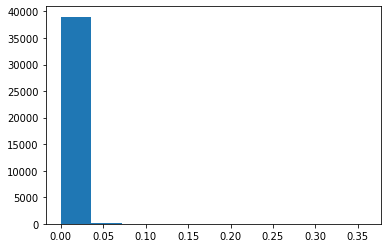

In [ ]:
plt.hist(op_list_dl)

In [ ]:
op_list_dl_t = np.log(op_list_dl_t)

In [ ]:
op_list_dl_t = op_list_dl_t[:,0]

In [ ]:
#op_list_dl_t = op_list_dl_t.reshape(1,-1)

In [ ]:
sum(Y)

339.0

In [ ]:
ir = IsotonicRegression()
ir.fit(op_list_dl,Y)
op_list_dl_t_res = ir.predict(op_list_dl_t)
# op_list_dl_t = op_list_dl_t.tolist()
# op_list_dl_t = [None,None] + op_list_dl_t

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

In [ ]:
op_list_dl_t_res

array([0.01398026, 0.01342756, 0.00923645, 0.00638607, 0.00851683,
       0.00851683, 0.0063887 , 0.00544774, 0.00229008, 0.00229008,
       0.00229008, 0.00544774, 0.00544774, 0.00532387, 0.00229008],
      dtype=float32)

In [ ]:
### deep learning w = 2
# model2 = load_model('model_tcn_w2_perfv1words_4.h5')
# A_perf2, A_words2, Y2 = shift_data(target_data, 2, v_perf+v_1, selected_new_all_sorted, 'label')
# op_list_dl2 = model2.predict([A_perf2, A_words2])
# op_list_dl2 = op_list_dl2.tolist()
# op_list_dl2 = [x[0] for x in op_list_dl2]
# op_list_dl2 = [None] + op_list_dl2



Text(0, 0.5, 'Overall Similarity')

Text(0, 0.5, 'Predicted Proba for SVM')

Text(0, 0.5, 'Predicted Proba for Deeplearning(T=3)')

([<matplotlib.axis.XTick at 0x7fde9fbfc850>,
 <a list of 17 Text major ticklabel objects>)

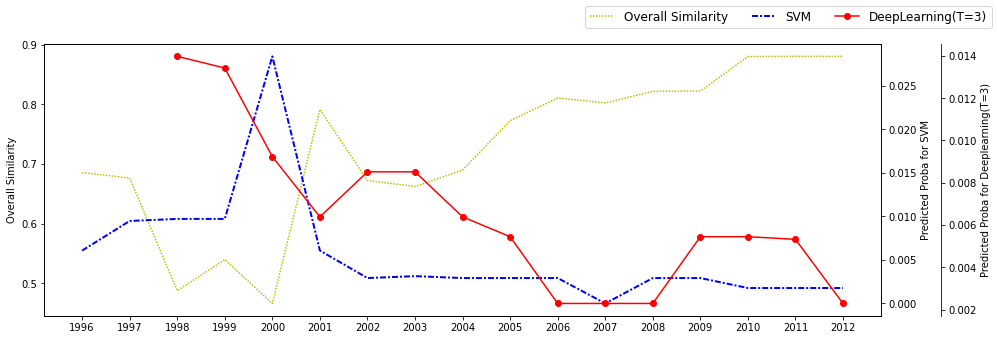

In [ ]:
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

fontP = FontProperties()
fontP.set_size('large')

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
ax4 = ax1.twinx()

#ax3.spines['right'].set_position(('outward', 60))
ax4.spines['right'].set_position(('outward', 60))

ax1.plot(target_data.y2, target_data.s1, linestyle=(0, (1, 1)), c= 'y' , label = 'Overall Similarity') #
ax2.plot(target_data.y2, op_list_svm_t, linewidth=2.0, c = 'b', linestyle=(0, (3, 1, 1, 1)), label = 'SVM')
#ax2.plot(target_data.y2, op_list_lg_t, linewidth=2.0,marker='.', c = 'g', linestyle=(0, (3, 1, 1, 1, 1, 1)), label = 'LogitReg')
#ax3.plot(target_data.y2, op_list_dl2, c= 'm' , marker='x', linestyle=(0, (5, 1)), label = 'DeepLearning(T=2)')
ax4.plot(target_data.y2, op_list_dl_t, c= 'r' , marker='o', label = 'DeepLearning(T=3)')
ax1.set_ylabel('Overall Similarity')
ax2.set_ylabel('Predicted Proba for SVM')
#ax3.set_ylabel('Predicted Proba of Deeplearning(T=2)')
ax4.set_ylabel('Predicted Proba for Deeplearning(T=3)')

#lt.xticks(mean_s_tb.index)
# ax1.plot(tbtb_temp.y2, temp_tb.nn_proba, linewidth=2.0, c = 'b',label = 'neualnet')
# ax2.plot(temp_tb.y2, temp_tb.s1, linewidth=2.0, c = 'g',label = 'overall similarity')
fig.legend(loc="best", prop=fontP,  ncol=5)
# ax1.set_ylabel('similarity score for fraud case')
# ax2.set_ylabel('similarity score for avg. overall similarity')

#ax1.scatter(target_data[target_data.label == 1].y2, target_data[target_data.label == 1].s1, c = 'r')
# ax1.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].nn_proba, c = 'b')
# ax2.scatter(temp_tb[temp_tb.label == 1].y2, temp_tb[temp_tb.label == 1].s1, c = 'g')

plt.xticks(target_data.y2)

# extra LSTM+TCN  
##### T= 2,3
##### variables:
##### Quant. Indicators + Overall Similarity  (T years) + Word Changes (current year)



In [ ]:
def model_tcn_ext(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding1D(padding=((0),(words-1)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv1D(filters = filters,\
                  kernel_size = words,\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    wrd_pool = MaxPooling1D(pool_size=words, \
              strides=1)(conv) # None x T x filters
    wrd_pool = Reshape((filters,))(wrd_pool)
    print("pool shape:", K.int_shape(wrd_pool))

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    #all_input = Concatenate(axis = -1)([perf_norm, pool])
    #all_rsp = Reshape((filters+15,))(all_input)
    #nor = BatchNormalization()(all_input)
    
    LSTM_w_1 =Bidirectional(LSTM(n1, recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    # kernel_regularizer = regularizers.l2(0.01),
                    # activity_regularizer = regularizers.l2(0.01),
                    # bias_regularizer = regularizers.l2(0.01)
                    ))(perf_norm)
    LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    all_input = Concatenate(axis = -1)([wrd_pool, LSTM_w_2])
    dense = Dense(n3, activation='relu', name='dense')(all_input)
    drop = Dropout(0.3)(dense)
    
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model

In [ ]:
def fit_model_ext( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    print('in fit, val_y: ', sum(y_val), 'test_y',sum(y_test), 'train_y',sum(y_train))

    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    #print('in fit val weights', val_sample_weights.shape)
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    # earlyStopping = EarlyStopping(monitor='val_loss',patience = 3, 
    #                   verbose =verbose, mode ='min')
    # checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
    #           save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])

    history = model_df.fit(x_train,
                y_train,
                epochs=25,
                batch_size=128,
                verbose =verbose,
                callbacks=[auc_eval],\
                #callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val, y_val, val_sample_weights)) 
    model_df.save(model_name+".h5")
    #model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
    print([ round(h,4) for h in history.history['val_loss']])    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [ ]:
def cross_val_ext(data, label, perf_cols, words_cols, name, w, filters = 24):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf,  X_word, Y = shift_data_ext(df_fl, w, \
                    perf_cols, \
                    words_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1]+ filters + 16
        
        model = model_tcn_ext(l1,l1,32,\
                    X_perf.shape[1],\
                    X_perf.shape[2],
                    X_word.shape[1], \
                    X_word.shape[2], \
                    filters = filters)
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        train_word_data = X_word[train_index]
        # train_perf_val = X_perf[train_val]
        # train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        train_data = [train_perf_data, train_word_data]
        #val_data = [train_perf_val,train_word_val]
        test_x = [test_perf_x, test_word_x]

        mod_res = fit_model_ext(model, train_data, train_label, test_x, test_y, test_x, test_y,\
                  name+'_'+str(c))
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [ ]:
def shift_data_ext(data, step, perf_cols, words_cols, label):
    A = []
    
    #cols = perf_cols + words_cols
    A.append(data[perf_cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[perf_cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    cols = [label] + words_cols
    A = np.concatenate([data[cols].values[:,], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape
    A_words = A[:,1:len(words_cols)+1]
    A_perfs = np.reshape(A[:,1+len(words_cols):], (len(A), step, len(perf_cols)))
    
    
    # CNN_LSTM must be None x T x words x 4
    #A_perfs = A[:, :, len(words_cols):]
    print(A_perfs.shape, A_words.shape, Y.sum())
    #convert the shape to [[_p,_new][_dis,_n]]

    A_words = A_words.reshape((len(A), int(len(words_cols)/4), 4), order = 'C')
    
    print(A_perfs.shape, A_words.shape, Y.sum())
    return A_perfs, A_words, Y

init A shape:  (53635, 86)
(39123, 3, 15) (39123, 40) 341.0
(39123, 3, 15) (39123, 10, 4) 341.0
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_13 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_90[0][0]     
__________________________________________________________________________________________________
conv1d_1

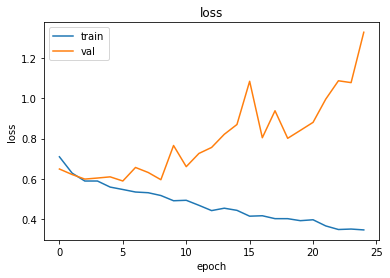

9781
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_14 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 10, 56)       2240        zero_padding1d_14[0][0]          


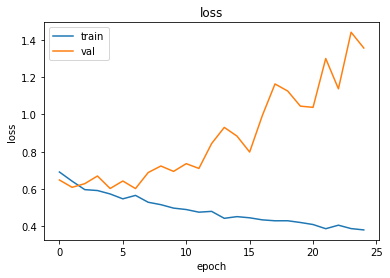

9781
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_15 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 10, 56)       2240        zero_padding1d_15[0][0]          


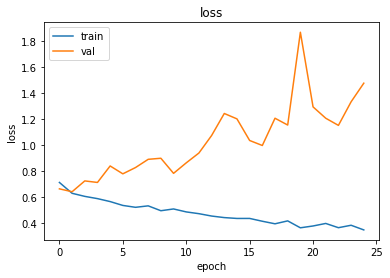

9781
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_16 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_99[0][0]     
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 10, 56)       2240        zero_padding1d_16[0][0]          


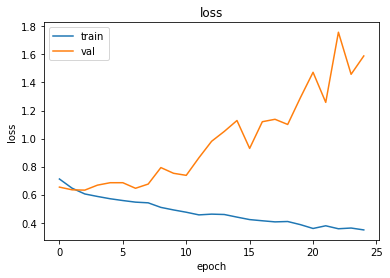

9780
avg_AUC :  0.7198541630253016
avg_AUC_2 :  0.7196935151791514
         0         1         2   ...        22        23        24
0  0.723624  0.721168  0.747959  ...  0.734002  0.740390  0.731124
1  0.713462  0.719701  0.729321  ...  0.717735  0.695783  0.713472
2  0.664532  0.684141  0.655907  ...  0.697186  0.692308  0.699473
3  0.694288  0.700853  0.705178  ...  0.689020  0.696859  0.699329

[4 rows x 25 columns]
0     0.698976
1     0.706466
2     0.709591
3     0.722340
4     0.704800
5     0.720964
6     0.715979
7     0.720123
8     0.718735
9     0.712176
10    0.721563
11    0.719861
12    0.713406
13    0.710300
14    0.710928
15    0.710347
16    0.717536
17    0.716705
18    0.718431
19    0.712026
20    0.714769
21    0.707672
22    0.709486
23    0.706335
24    0.710850
dtype: float64


In [ ]:

#use  model_tcn_ext, shift_data_ext, cross_val_ext
#T=3
#Quant. Indicators + Overall Similarity  (T years) + Word Changes (current year)


w = 3
perf_cols =   v_perf +v_1
words_cols =  selected_new_all_sorted
label = 'label'
h3 = cross_val_ext( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_ext_w3',w, \
          filters = 56)

init A shape:  (53635, 71)
(45945, 2, 15) (45945, 40) 408.0
(45945, 2, 15) (45945, 10, 4) 408.0
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_17 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_102[0][0]    
__________________________________________________________________________________________________
conv1d_1

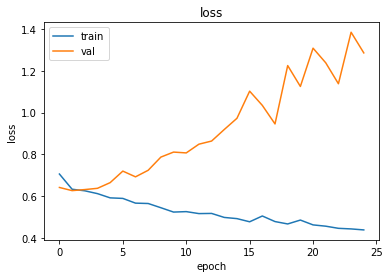

11487
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_18 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_105[0][0]    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 10, 56)       2240        zero_padding1d_18[0][0]          

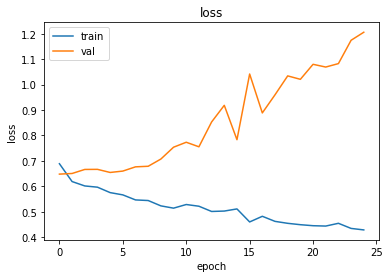

11486
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_19 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_108[0][0]    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 10, 56)       2240        zero_padding1d_19[0][0]          

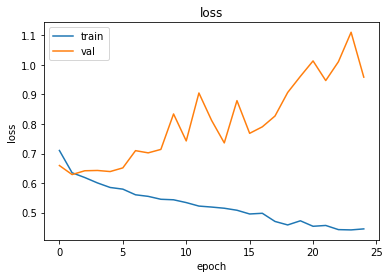

11486
shape after padding: (None, 19, 4)
conv shape: (None, 10, 56)
pool shape: (None, 56)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 10, 4)        16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding1d_20 (ZeroPadding1 (None, 19, 4)        0           batch_normalization_111[0][0]    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 10, 56)       2240        zero_padding1d_20[0][0]          

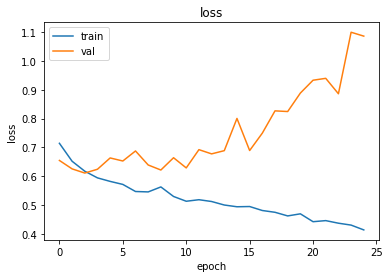

11486
avg_AUC :  0.70405180182151
avg_AUC_2 :  0.7038646266587443
         0         1         2   ...        22        23        24
0  0.712675  0.709633  0.697938  ...  0.686912  0.685741  0.685311
1  0.686028  0.698829  0.711031  ...  0.718967  0.706327  0.715288
2  0.698850  0.714154  0.710972  ...  0.678622  0.681584  0.690897
3  0.687462  0.709463  0.727418  ...  0.724465  0.714783  0.711385

[4 rows x 25 columns]
0     0.696254
1     0.708020
2     0.711840
3     0.715005
4     0.716013
5     0.705840
6     0.712228
7     0.713001
8     0.709183
9     0.708169
10    0.711683
11    0.708617
12    0.705530
13    0.704048
14    0.699656
15    0.706707
16    0.706460
17    0.705994
18    0.701631
19    0.694675
20    0.699790
21    0.703442
22    0.702242
23    0.697109
24    0.700720
dtype: float64


In [ ]:
#use  model_tcn_ext, shift_data_ext, cross_val_ext
#T=2
#Quant. Indicators + Overall Similarity  (T years) + Word Changes (current year)
w = 2
perf_cols =  v_1 + v_perf
words_cols = selected_new_all_sorted
label = 'label'
h3 = cross_val_ext( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_ext_w3',w, \
          filters = 56)